<div style="max-width:800px; margin-left:50px; margin-right:50px; mask-image:none background:none">

<div style="width:100%; height:auto; mask-image: linear-gradient(to bottom, transparent 0%, black 3%, black 97%, transparent 100%);">

<div style="float:right; margin:20px 10px 10px 10px; width:40%; padding:20px; background:#dddddd; color:#555555; font-size:80%; mask-image:none; z-index: 10; box-shadow: -5px 5px 5px rgba(0, 0, 0, .5);"> 

**Welcome to this partially completed notebook!**

Working on this project is a near-full-time pursuit at the moment!  I'm sharing this work-in-progress so that you can check it out.  I hope you'll find it interesting!

I'll push a new snapshot of the working copy whenever something worth sharing comes up.  In the meantime: **Pardon the dust, and sinecerely: thanks for checking this out!**

**Reed**

Changelog:

| Date/time | Updates |
|---|---|
| 2024-06-10   | Initial snapshot push |

</div>


<div style="z-index:-1; background:white; padding-top:20px; padding-bottom: 20px; height:400px; width:100%;  ">
<div style="float:left; backround: white; padding:20px 0px 20px 20px; width:400px; color:#222222;">
<img style="height:auto; margin:20px 20px 0px 0px; background-size: cover; " src='img/sparkmark3.png'> 
<h1 style="margin-bottom:5px; padding-bottom:0px;"><strong>The Prompt Annealer</strong></h1>
<p style="margin:0px; padding:0px 0px 0px 20px;"><b>Reed Taylor, 2024</b></p>

</div>
</div>
</div>
</div>

<div style="max-width:800px; margin-left:50px; margin-right:50px ">

# Context

Anthropic's User Guide provides a graphic (screenshot below; original [here](https://docs.anthropic.com/en/docs/prompt-engineering)) that depicts the inherently iterative process of prompt engineering:
<div style="width:50%; height:220px; margin-left: 25%; background-image: url('img/anthropic_guide.png'); background-size: cover; mask-image: linear-gradient(to bottom, transparent 0%, black 30%, black 70%, transparent 100%);"></div> 

That approach makes sense both when working with massive & robust API-gated models, and also when working with the smaller models often suited to use near "the Edge".  

**Smaller locally-deployed models can be vexingly sensitive to prompt details**<br/>
Big, small, even spurious changes to a prompt can create or reduce struggles with e.g. tool use, output formatting, and agent-related tasks. [[1]](https://arxiv.org/abs/2305.16504)  [[2]](https://arxiv.org/abs/2310.11324)  This makes iterative engineering even more important -- and demanding -- in an edge-focused use-case.

**Locally-deployable models are advancing at a blistering pace**<br/> 
A new front=runner emerges and begs for evaluation almost every week, it seems.  In the grand scheme, this is great news for the edge-focused prompt engineer.  But it takes significant effort to stay near the leading-edge, and that can become tiring and hard to rationalize when well-engineered prompts become obsolete within days of deployment.  

Worse, the specializations found to be effective on yesterday's best model might be unnecessary or even counterproductive on tomorrow's.  Expanding upon Anthropic's graphic above, I sketched that additional part of the prompt lifecycle:
<img style="width:80%; margin:15px 10% 15px 10%" src="img/model_drop.png">


With the challenges above in mind:<br/>
**The Annealer aims to minimize recurring, manual engineering effort with short-lived value.**
 
 **It automates the empirical, exploratory process of system prompts engineering, producing customized prompts that lean into the strengths of a model-du-jour, whatever they may be.**

Here's how:

<div style="max-width:800px; margin-left:50px; margin-right:50px ">

# Introduction

## Annealing: *Getting Cooler All The Time*

(Caution: I know more about puns than I do about materials science.)

**"Annealing" is the name of a useful materials process.** This generally involves:
1. Starting with something really, really hot
2. intentionally cooling that thing down really, really slowly

Annealing can change the physical properties of some metals, glass, plastics, and other things.  Annealed materials tend to be stronger & more durable than they would otherwise be.  

When heated beyond certain temperatures, these materials soften their internal structure, becoming amorphous, and not organized into well-structured crystals.   If cooled quickly, those internal particles will settle into a collectively "disorganized" state -- irregularities and internal stresses become "frozen" and embedded into the material itself.

<div style="float:right; width:30%; margin:15px 0px 5px 15px; padding-bottom:5px; text-align:center; background-color: rgba(255, 255, 255, 0.05); "><img src="img/drop.gif"><br/>Not Annealed</div>Often, this means the materials will be harder or stiffer.  In some cases, that can be useful; in other cases, it may make them harder to work with -- notably, with glass: Rapid cooling can produce parts that spontaneously break, or even explode under stress!  (SmarterEveryDay's Destin leveraged this to make some awesome [slo-mo videos](https://www.youtube.com/watch?v=xe-f4gokRBs); typically though, glassblowers will anneal their pieces specifically to avoid such outcomes.)

**In ambiguously aphysical terms, here's how slowly cooling helps achieve a more "optimal" outcome:**<br/> 
If we think of the particles in a material comprising a "system", their collective arrangement could define the "state" of that system.  High temperatures allow these particles freedom to move around -- and in doing so, they transition the system from its initial state through a long series of "neigboring" states.   

The process of controlled cooling affords the particles a means to to find "good seats” for themselves in the end-state --  that is, to find places to hang out more comfortably in the end-state, once things have fully cooled.   Collectively better-otrganizes, this means the system has "discovered" a lower-energy overall state to wind up in!  When annealing "works", this end-state will be meaningfully lower-energy (i.e. better-optimized) than any state that could have been reached by racing to a near-neighbor of the start-state -- as would happen with rapid cooling.

</div>


<div style="max-width:800px; margin-left:50px; margin-right:50px">

### Getting into Simulated Annealing (before it's cool)

 Simulated annealing is an optimimzation process loosely modeled on the physical process.  In general:


- <div style="float:right; width:40%; margin:15px 0px 5px 15px; padding-bottom:5px; text-align:center; background-color: rgba(255, 255, 255, 0.05); "><img src="img/salesman_annealing.gif">Cool traveling salesman demo<br/><a href="https://toddwschneider.com/posts/traveling-salesman-with-simulated-annealing-r-and-shiny/#salesman-app)">from Todd W. Schneider</a></div>Simulated annealing defines a problem in terms of a system with a known, scoreable state that can move to neighboring states. Those neighbors may score better or worse than their predecessors.
- Optimization is iterative; each iteration has a "temperature", and each iteration proposes moving to a randomly-identified neighbor of the current state.   
- Annealing begins at a high temperature, allowing the system to move wherever it wants.  In practical terms this means that -- at least initially -- we'll accept pretty every neighbor-move regardless of whether it's better, or worse -- even if it's a LOT worse. 
- Annealing gradually cools the system down as iterations progress.  Cooling reduces the system's appetite to accept unfavorable moves.  Correspondingly, the system progressively settles toward more optimal states, exploiting randomly discovered improvements without just moving... wherever.
- We end up cooling into a solution that’s -- hopefully -- close to a global optimum.


</div>


<div style="max-width:800px; margin-left:50px; margin-right:50px ">

# 🛠️ Application 

### Why Apply Simulated Annealing to Prompt Engineering?

I will admit that I have a certain nostalgic affection for simulated annealing, which made me curious to revisit the approach to see how well it could be adapted to this situation, and (of course) to see how well it might perform!

With that said, simulated annealing (and metaheuristics in general) do have some appealing characteristics for problems where: 
- Exhaustive search is computationally intractable -- e.g. the travelling salesman example above
- The cost landscape has many local optima, and local / greedy search is unlikely to do well
- The solution space is too high-dimensional for approaches (e.g. Bayesian optimization) that scale poorly as dimensionality rises/

I did a non-rigorous search and found a number of prompt-tuning and optimizaiton implementations on Github and in some published papers, but these seemed mostly to have been either: 
- Examples of "Prompt optimization", i.e focused on exploiting / searching a small local neighborhood.  (In the general case approaches such as these seemed very likely to get stuck in cost basins/)
- Bayesian and similar optimizations necessarily tailored to exploring the prompt-space from the perspective of reduced dimemsionality.  

Inspired in part by the impressive output of [Anthropic's Metapropmpt](https://docs.anthropic.com/en/docs/helper-metaprompt-experimental), I was interested to leverage LLMs in a more open-ended approximation of how a human might approach the task of prompt engineering, knowing a priori that the best-performing prompts could be ... well, anything.  So I liked the idea of tackling the problem without any formal limits.  

</div>

<div style="max-width:800px; margin-left:50px; margin-right:50px ">


## Approach - Overview

<div style="width:80%; margin-left:10%" ><img src="img/anealer_text_blocks.png"></div>

_TODO: writeup_

</div>

<div style="max-width:800px; margin-left:50px; margin-right:50px ">

### Initial Implementation

<div style="width:80%; margin-left:10%"><img src="img/anealer_full_blocks.png"></div>

_TODO: writeup of approach_

</div>

<div style="max-width:800px; margin-left:50px; margin-right:50px ">

## Challenges

### Evaluation:  Task-specific guidance for Task-agnostic criteria 

It is/was a goal to have the evaluation framework _NOT_ require specialization to fit a user's objective.  This meant developing (and analyzing / refining) a set of general purpose evaluation criteria and rubrics, aiming to adhere to some collective principles:

- **Comprehensiveness:** Do the criteria jointly capture and discourage all the expected and/or identifiable quality loss mechanisms that persist through optimization?
- **Efficiency:** The criteria are evaluated many, many times.  Are they achieving a successful balance between their costs (mainly in terms of latency) and their effectiveness (in terms of result quality and other factors)?
- **Safety:** Given the scenario / use-case, are the criteria able to minimize potential harm / abuse issues?  

With those principles in mind, there are some related measurable traits that can be used to assess and improve criteria, rubrics, and base-prompts:
- **Reliability,** i.e. tuning prompts, criteria, and rubrics to reduce within-criterion statistical variance across repeat trials. Inter-rater reliability scoring approaches may be relevant.  Specificity, validity, and objectivity might be proxied here.  This is also clearly important when tuning token-efficiency.
- **Orthogonality,** i.e. tuning individually and collectively to reduce pairwise correlations among criteria, which could proxy for the “span” of information they yield, assuming they are consistently measuring real things.
- **Dynamic range,** i.e. tuning (especially the rubrics) so that the judges generate score distributions that are favorable for sensitivity and discrimination

##### The Problem: 
Initial testing demonstrated that the evaluators were not able to function consistently within a single run: 

<div style="width:80%; margin-left:10%"><img src="img/eval_before.png"></div>

Reading the evaluators' output reasoning, it was evident even without quantitative analysis that the they were confronted with a task that was too open-ended.  Each individual [example,criterion] eval required (re)interpretation of the task-agnostic rubrics, in the context of the specific current objective.  In many cases this left a great deal of room for interpretation, and absent a more consistent context this led to wide variance in the raters' within-task behavior.

For example, given a user-provided objective like _"Use provided tools to perform math operations"_: There is more than one reasonable way to interpret "Relevance" even given a firm rubric, and that interpretation was very often swayed by tokens in the outputs and reference examples themselves.  Result being: poor within-task inter-rater reliability, weaker cost function, leaky quality issues etc.

**Solution:**  Stabilize within-task rater performance without sacrificing the flexibility of task-agnostic criteria by generate concrete, task-specific guidance for each criterion / rubric and providing this to raters as part of their evaluation prompt.

<div style="width:80%; margin-left:10%"><img src="img/eval_after.png"></div>

*TODO: make this section less rough*

*Also -- for the record -- I have a great deal of quantitative analysis to do before I'd want to put a stake in the ground on many of the observations below.  If anyone reads this, they should take what's here as approximating what I hope to write, given what I've observed, but as yet without much evidence.*

Most importantly, the granular [objective, criterion] guidance makes the individual eval tasks less subjective.  This helps address the observed problems with self-consistency (i.e. inter-rater reliability, within tasks).

The prescriptive guidance is also beneficial to eval rater efficiency.  Because the guidance is task-aware, the span of e.g. few-shot examples that need to be covered in the task-agnostic base prompt drops dramatically, since we don't need to inform the raters about a broad, hypothetical landscape.  This concreteness should translate to fewer tokens-per-eval (without quality-loss), which is significant as the latency of ratings is critical to the end-to-end runtime for each iteration.  

And - the range of acceptable interpretation of criteria widens with the guidance flow in place.  For example, I would have written eval prompts that discouraged standalone eval raters from interpreting e.g. "harmlessness" to mean something like "making well-formed function calls when using tools" because -- in the absence of any context -- that interpretation seems to stray fairly far from the original meaning.   But, if a holistic guidance planner KNOWS that e.g. due to the nature of the underlying task (e.g. "use tools to solve math equations; responses will be parsed into json objects that accept only a float"), and e.g. the criteria "accuracy" and "correctness" already having taken care of the other ways a numerical answer might be considered "harmful" -- then, sure -- cover some other base with that criterion!   This kind of flexibility may allow for more overall outcome-value per eval-inference-token.

**Notes on the approach**

The separation of the guidance-generation into multiple steps had two motivations.  First, and more straightforward was performance and cost: the total context window required for both the prompt (including all the criteria), the objective, and few-shot examples of guidance - plus the generation of N individual guidance items, was quite large.  Even large and capable models like Claude-3-opus had a tendency to stop short of generating all N required guidance items, which in turn meant re-running the prompt, at what could amount to considerable expense both in latency (albeit one-time startup latency), and in paid token-count, and also in saturating rate-limiting  quotas.

Second was complexity.  The task of sizing up the collective ensemble of criteria, alongside the objective, and returning a plan for how they might all be jointly aligned -- this is not "simple" by any means, but it also is in essence a summarization-type task, and it seems to fall well within the capabilities of Claude-3-opus to generate what subjectively seem to be sane and often thoughtful such plans.

Likewise - with a single holistic plan already pulled together, it becomes much easier to break apart the task of generating N guidance items into N separate tasks, each generated independently by a guidance-generating prompt that reads the same (entire, holistic) plan.  The effort and complexity in the presence of a unifying pre-authored plan of guidance-authoring becomes much easier to think of as a parallelizable job.


#### Missing Pieces

It's clear from qualitatively observing a few test runs that there's more work to be done on the evaluation pipeline.  Here are a few top-of-mind things that I'm looking forward to implementing, but that haven't been done yet:

**Real (target) examples for Guidance generators**  Guidance authors would clearly benefit from exposure to a few task-specific, real-world examples of what the target model's actual inputs look like.  I hesitate to call these "few-shot examples because they aren't actually examples generated guidance for evaluators OR of evaluation input/output either -- the target model inputs & reference outputs are actually two steps removed from the actual task of the guidance author. Nonetheless: I saw a case where: 
- the objective was written as "use available tools to exactly repeat the input text".
- The guidance generator for "accuracy" authored guidance suggesting a task specific rubric where "mistakes of only a few words should still get a high score."  
- But, the actual underlying task was a tool-usage benchmark, with the target model required to use a laborious "typewriter" tool requiring one tool-call for every letter repeated.  So, most of the benchmark dataset was in fact single-word examples, with between 5 and 15 characters each.
- So, the well-intentioned guidance for the "accuracy" evaluator to let "mistakes of a few words" slide, was totally confounding.  

This could be addressed by giving the guidance generator visibility into a few examples drawn from the annealing dataset, but this introduces complexity if we want to remain principled about how that data enters the pipeline.  That example could certainly leak directly into guidance, and into the prompts, and then into the target model's performance.  None of this couldn't be handled, it just deserves some care.

**Real (target) examples for few-shot in neighbor generation**  Somewhat similar to the above, it would be helpful to enable the Neighbor Generation pipeline to add examples that aren't entirely hallucinated.   Also similar to the above, this would certainly require some specific means of handling the available few-shot examples separately from the eval / annealing data.

**Equip Guidance Planning to steer the cost function** Guidance planning clearly knows that certain criteria matter more / differently than others.  We could give it some simple, bounded choices (e.g. linear/nonlinear and low/medium/high weight) to help influence how the scores its plan producesa are to be combined.  Likewise the door is open to zero-weight cases where e.g. it deems a criterion wholly unnecessary.  While this merits careful thought, the performance bottleneck at evaluation probably merits the work.

[todo: import more from here and there in the code & in various notes]

</div>


<div style="max-width:800px; margin-left:50px; margin-right:50px ">


#### Other problems worked through
_TODO: write these up in a reasonable way_

- Framework getting in the way -- langchain wasn't clearly a net-win for ease of use or performance.
- Surprising lack of clarity on when/where fine-grained prompt specifics e.g. special instruction-tuned tokens are under my control (slash responsibility), vs being "magically" handled by one or more embedded layers of the frameworks & APIs, which can be black-box like.  Lesson: don't trust anyone!  Many things that DO matter are NOT being done correctly.
- Gracefully handling transient vs real-but-ignorable vs systemic failures
- Consistent & capable development environments
- Structured output from models of different sizes / etc.
- Means to enable tool usage another API specifics without requiring a great deal of specialized code
- Tie more directly into pre-existing benchmark / dataset ecosystem for both annealing and "outside-the-loop" evaluation / confirmation of result quality


#### More future work - not related to guidance/eval
- Tune cost function (it's just in some guesswork state pending real stats to improve it)
- Restore tool use capability to the existing code (removed during a refactor)
- Refactor python out of the notebook into modules; separate discussion and analysis into less cumbersome notebooks
- ...



## Implentation Details  -- The code!



#####  🖥️ Setup, Initialization, Interfaces, and other Utilities 

Important, useful, but not very interesting. :yawning_face:

###### 💻 **Code:** Dependencies, Imports, and Setup 

In [1]:
# pip installs (uncomment)

# %pip install ipywidgets tqdm matplotlib numpy pandas seaborn scipy torch torchvision tiktoken einops vllm langchain-anthropic langchain-openai langchain langchainhub langchain-experimental sqlitedict

# for notebook exports etc.
# %pip install notebook jupyter_contrib_nbextensions


In [2]:
ANNEALING_SESSION_NAME = "Annealer-TEST04"  # Using a stable session name for testing


In [3]:
### ANNEALING_SESSION_NAME: If not set, generate some timestamped strings
import datetime

if "ANNEALING_SESSION_NAME" not in globals():
    ANNEALING_SESSION_START_TIME: str = datetime.datetime.now().strftime(
        "%Y%m%d-%H%m%S"
    )
    ANNEALING_SESSION_NAME: str = f"Annealer-{ANNEALING_SESSION_START_TIME}"


In [4]:
### All-purpose Imports
import os
from dotenv import load_dotenv
import random
from functools import partial
import re
import json
from collections import namedtuple
from datetime import datetime
from typing import Any, Dict, List, Literal, Optional, Set


import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError
from scipy.stats import logistic

from sqlitedict import SqliteDict


###### 💻 **Code:** LangChain & LangSmith Setup 

In [5]:
### LangChain / LangSmith Imports & Initialization
from langchain import hub as lc_hub
from langchain_core.language_models import (
    BaseLanguageModel as lc_BaseLanguageModel,
    BaseChatModel as lc_BaseChatModel,
)
from langchain_core.runnables import (
    Runnable as lc_Runnable,
    RunnablePassthrough as lc_RunnablePassthrough,
    RunnableParallel as lc_RunnableParallel,
)
from langsmith import Client as ls_Client
from langsmith import traceable
from langsmith.schemas import (
    Example as ls_Example,
)
from langsmith.schemas import (
    Run as ls_Run,
)
from langsmith.schemas import (
    TracerSession as ls_TracerSession,
)

load_dotenv()
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = "key"
# os.environ["LANGCHAIN_HUB_API_URL"] = "https://api.hub.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = ANNEALING_SESSION_NAME

LS_CLIENT: ls_Client = ls_Client()
try:
    LS_PROJECT = LS_CLIENT.create_project(
        project_name=ANNEALING_SESSION_NAME,
        description="Prompt Annealing session",
    )
except Exception as e:
    if "already exists" in str(e):
        print("LangSmith project already exists, using it")
        LS_PROJECT = LS_CLIENT.read_project(project_name=ANNEALING_SESSION_NAME)
    else:
        raise e


LangSmith project already exists, using it


In [6]:
### LangChain Prompt Imports
from langchain_core.prompts import (
    ChatPromptTemplate,
    PromptTemplate,
    BasePromptTemplate as lc_PromptTemplate,
)
from langchain_core.prompts.pipeline import PipelinePromptTemplate
from langchain_core.prompts.chat import MessageLikeRepresentation


###### 💻 **Code:** Models & Inference APIs Setup 

In [7]:
### Anthropic API Imports & Initialization
from langchain_anthropic import ChatAnthropic

# os.environ["ANTHROPIC_API_KEY"] = ("key")
anthropic_claude_3_opus_model = ChatAnthropic(model_name="claude-3-opus-20240229")  # type: ignore
anthropic_claude_3_sonnet_model = ChatAnthropic(model_name="claude-3-sonnet-20240229")  # type: ignore
anthropic_claude_3_haiku_model = ChatAnthropic(model_name="claude-3-haiku-20240307")  # type: ignore


In [8]:
###  Ollama API Imports & Initialization
from langchain_community.chat_models.ollama import ChatOllama
from langchain_experimental.llms.ollama_functions import (
    OllamaFunctions,
)


def get_local_ollama_model(
    type: Literal["chat", "functions"] = "chat",
    model: str = "llama3:latest",
    format: Optional[Literal["json"]] = None,
    base_url: str = "http://localhost:11434",
    **kwargs,
) -> ChatOllama:
    if type == "chat":
        return ChatOllama(model=model, format=format, base_url=base_url, **kwargs)
    elif type == "functions":
        return OllamaFunctions(model=model, format="json", base_url=base_url, **kwargs)
    else:
        raise ValueError(f"Unknown Ollama model type: {type}")


def get_helicopter_ollama_model(
    type: Literal["chat", "functions"] = "chat",
    format: Optional[Literal["json"]] = None,
    **kwargs,
) -> ChatOllama:
    return get_local_ollama_model(
        type=type, base_url="http://10.0.1.21:11434", format=format, **kwargs
    )


def get_desktop_ollama_model(
    type: Literal["chat", "functions"] = "chat", **kwargs
) -> ChatOllama:
    return get_local_ollama_model(
        type=type, base_url="http://10.0.2.100:11434", **kwargs
    )


In [9]:
# VLLM
from langchain_community.llms.vllm import VLLMOpenAI
from langchain_openai import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser as lc_PydanticOutputParser
from langchain_core.output_parsers import XMLOutputParser as lc_XMLOutputParser
from langchain_community.llms.vllm import VLLM as lc_VLLM

os.environ["VLLM_NCCL_SO_PATH"] = (
    "/usr/local/lib/python3.10/dist-packages/nvidia/nccl/lib/libnccl.so.2"
)


def get_remote_vllm_completion_model(
    model: str = "NousResearch/Meta-Llama-3-8B-Instruct",
    api_base: str = "http://10.0.1.21:18000/v1",
    model_kwargs: Dict[str, Any] = {},
    **kwargs,
) -> VLLMOpenAI:
    completion_llm = VLLMOpenAI(
        model=model,
        openai_api_key="vllm",  # type: ignore
        openai_api_base=api_base,  # type: ignore
        model_kwargs=model_kwargs,
        **kwargs,
    )
    return completion_llm


def with_structured_output(
    self: VLLMOpenAI, schema: Dict | type[BaseModel], **kwargs: Any
) -> lc_Runnable:  # [LanguageModelInput, Dict[Unknown, Unknown] | BaseModel]
    """Monkey patch to allow for structured output from VLLM at least the way I'm doing it"""
    if isinstance(schema, dict):
        raise NotImplementedError("Not implemented yet")
    _new_model: VLLMOpenAI = self.copy()
    _new_model.callbacks = self.callbacks
    _new_model.tags = self.tags
    _new_model.metadata = self.metadata
    _new_model.client = self.client

    _json_schema_str = json.dumps(schema.schema())
    if not _new_model.model_kwargs.get("extra_body"):
        _new_model.model_kwargs["extra_body"] = {}
    _new_model.model_kwargs["extra_body"]["guided_json"] = _json_schema_str

    _parser = lc_PydanticOutputParser(pydantic_object=schema)
    _chain = _new_model | _parser
    return _chain


# Monkey patch VLLM to allow for structured output
VLLMOpenAI.with_structured_output = with_structured_output


def get_remote_vllm_chat_model(
    model: str = "NousResearch/Meta-Llama-3-8B-Instruct",
    api_base: str = "http://10.0.1.21:18000/v1",
    model_kwargs: Dict[str, Any] = {},
    **kwargs,
) -> ChatOpenAI:
    chat_llm = ChatOpenAI(
        model=model,
        api_key="vllm",  # type: ignore
        base_url=api_base,
        model_kwargs=model_kwargs,
        **kwargs,
    )
    return chat_llm


from langchain_experimental.llms import LMFormatEnforcer


class VLLMLocal(lc_VLLM):
    def with_structured_output(
        self, schema: Dict | type[BaseModel], **kwargs: Any
    ) -> lc_Runnable:
        raise NotImplementedError("Not implemented yet")


def get_local_vllm_completion_model(
    model: str = "NousResearch/Meta-Llama-3-8B-Instruct",
    model_kwargs: Dict[str, Any] = {},
    client: Any = None,
    **kwargs,
) -> VLLMLocal:
    local_llm = VLLMLocal(
        model=model,
        trust_remote_code=True,
        vllm_kwargs=model_kwargs,
        client=client,
    )
    return local_llm


###### 💻 **Code:** Utility / Interface Classes 


In [10]:
class LangChainDataset(BaseModel):  # Set up & manage state for LangChain Datasets.
    name: str
    input_var_set: Set[str] = set()

    def __init__(self, **data):
        super().__init__(**data)
        print(f"LangChainDataset initializing with name: {self.name}")
        try:
            if not LS_CLIENT.has_dataset(dataset_name=self.name):
                LS_CLIENT.read_dataset(dataset_name=self.name)
        except Exception as e:
            raise LookupError(f"Could not load dataset {self.name}, error: {e}")

        _dataset_input_vars: List[str] = list(self.examples[0].inputs.keys())
        self.input_var_set.update(_dataset_input_vars)

    @property
    def examples(
        self,
        # dataset_name: Optional[str | None] = None,
    ) -> List[ls_Example]:
        """Surfaces a list of all examples in a the dataset

        Returns:
            List[ls_Example]
        """
        return list(LS_CLIENT.list_examples(dataset_name=self.name))

    @property
    def example_inputs(self) -> List[Dict[str, Any]]:
        """Returns all inputs from the dataset in a single list"""
        return [example.inputs for example in self.examples]

    @property
    def example_reference_ouputs(self) -> List[Dict[str, Any]]:
        """Returns all inputs from the dataset in a single list"""
        return [example.outputs or {} for example in self.examples]

    def get_random_example(self) -> ls_Example:
        """Returns a single randomly selected example from the active dataset

        Returns:
            ls_Example
        """
        return random.choice(self.examples)

    @classmethod
    def from_source_dataset_name(
        cls,
        source_dataset_name: str,
        client_dataset_name: str = "",
        client_dataset_limit: Optional[int] = None,
    ) -> Any:
        """Copies an existing (source) dataset to a new dataset in the client.
        The new dataset is the one that will be used for each iteration evaluation.
        Copying to a new dataset in this manner fits the annealing approach into
        the way LangSmith likes to organize its evaluate() results.

        Args:
            source_dataset_name (str): existing langsmith dataset to copy.

            client_dataset_name (str, optional): "Unique" name for the dataset
                created for annealing.  Defaults to a combination of source_dataset_name
                and the ANNEALING_SESSION_NAME.  If that client_dataset_name already
                exists in the client, we catch the exception and (re)use it. (Typically
                happens when e.g. restarting an aborted session.)

                limit (Optional[int], optional): Limits the number of examples copied
                from source_dataset into client_dataset.  Precisely which examples
                get copied is LangSmith-defined (and unknown to me) -- so as implmeneted
                this is intended for "quick-test" subsetting -- not for "principled"
                / consistent subsetting (e.g. for isolating training / eval sets).
                Defaults to None, i.e. "All examples"

            client_dataset_limit (Optional[int], optional): If set, limits the number of examples
                copied from the source dataset.  Intended for quick debugging / testing (not
                for e.g. training / eval separation).  Defaults to None.

        Returns:
            Any: some kind of LangSmith dataset object that isn't very well documented,
        """
        if not client_dataset_name:
            client_dataset_name = source_dataset_name + f"-{ANNEALING_SESSION_NAME}"

        _examples = list(
            LS_CLIENT.list_examples(
                dataset_name=source_dataset_name, limit=client_dataset_limit
            )
        )
        _inputs = [_example.inputs for _example in _examples]
        _outputs = [_example.outputs for _example in _examples]
        try:
            LS_CLIENT.create_dataset(dataset_name=client_dataset_name)
        except Exception as e:
            if "already exists" in str(e):
                print(
                    f"Client dataset {client_dataset_name} already exists.  Reusing without changes!"
                )
                # TODO: tag the dataset with a version
            else:
                raise e
        else:
            LS_CLIENT.create_examples(
                inputs=_inputs,
                outputs=_outputs,
                dataset_name=client_dataset_name,
            )

        _lcd = LangChainDataset(
            name=client_dataset_name,
        )
        return _lcd

    @classmethod
    def from_dataset_name(
        cls,
        dataset_name: str,
    ) -> Any:
        _lcd = LangChainDataset(
            name=dataset_name,
        )
        return _lcd


In [11]:
class LangChainConfig(  # 'Root' class to setup & manage the state of LangChain objects
    BaseModel
):
    dataset: LangChainDataset

    @property
    def project(self) -> ls_TracerSession:
        return LS_PROJECT

    @classmethod
    def from_dataset_object(cls, dataset: LangChainDataset, **kwargs) -> Any:
        _lc = cls(
            dataset=dataset,
            **kwargs,
        )
        return _lc

    @classmethod
    def from_source_dataset_name(
        cls,
        source_dataset_name: str = "annealing_target_dataset",
        client_dataset_name: str = "",
        client_dataset_limit: int | None = None,
        **kwargs,
    ) -> Any:
        _lcd = LangChainDataset.from_source_dataset_name(
            source_dataset_name=source_dataset_name,
            client_dataset_name=client_dataset_name,
            client_dataset_limit=client_dataset_limit,
        )

        _lc = cls(
            dataset=_lcd,
            **kwargs,
        )
        return _lc


### 🎛️ Configuration 

Annealing proceeds with the following user configuration in place:
- Annealed prompt objective
- Dataset to drive the optimization process
- Annealed prompt input config:
    - Where in the prompt they should be located (system message, first user message, etc.)
    - Dataset input vars are considered automatically, but config can specify any others e.g. `agent_scratchpad`, `chat_history` etc. 
- Models, including:
    - Annealing Target Model selection & config
    - Models selections and configurations for all the internal LLM-driven stages of annealing
- Maximum number of iterations to run

The above is captured in a set of **Configuration classes**.  Usage and code in this section.

##### 🔎 **Details:** Configuration classes 



**Usage:** Here's an example of how the configuration classes might get populated:

>```python
>## Prepare various configuration subcomponents, e.g. objective, model selections
>_objective: str = "Give brief factual responses to questions.  Respond with 'response' and 'reasoning' in a JSON object."
>
># Define an output schema (not required, but in this case the objective calls for it)
># using a Pydantic class
>class MyResponse(BaseModel):
>    """ Represents the response to a user's question, and the reasoning behind it"""
>    response: str,
>    reasoning: str
>
># Select & prep the target model, so it's ready to generate output with that schema
>_target_model = get_local_ollama_model(type="functions")
>_target_model_with_structure = _target_model.with_structured_output(schema=MyResponse)
>_models = AnnealerModels(
>    target=_target_model_with_structure
>    # [... other models can be selected here...]
>) 
>
>## Generate the config object using the above config items:
>ac: AnnealerConfig = from_objective_and_source_dataset_name(
>    objective=_objective,
>    models=_models
>    source_dataset_name="my_question_dataset",
>)
>```

###### 💻 **Code:** Config classes 

In [12]:
# AnnealerModels
# This namedtuple represents the user's selection and fine-grained configuration of the models, tokenizers, and parsers to be
# used at each independent stage of the annealing process. (Including selecting the target!)

# The choices are all instantiated as references within this object, when it's initialized.


AnnealerModels = (
    namedtuple(  # Pick & configure all the annealing models (and target model!)
        "AnnealerModels",
        [
            "bootstrap",
            "guidance_planning",
            "guidance_generation",
            "output_evaluator",
            "neighbor_generation",
            "target",
        ],
        defaults=[
            None,  # anthropic_claude_3_opus_model, # prompt bootstrap
            anthropic_claude_3_opus_model,  # guidance planning
            anthropic_claude_3_sonnet_model,  # guidance generation
            anthropic_claude_3_haiku_model,  # output evaluation
            anthropic_claude_3_haiku_model,  # neighbor generation
            anthropic_claude_3_haiku_model,  # annealing target
        ],
    )
)


In [13]:
class AnnealerDiskCache(BaseModel):
    file_name: str = "annealer_disk_cache.sqlite"
    table_name: str = ANNEALING_SESSION_NAME

    disk_cache: Optional[SqliteDict] = None

    class Config:
        arbitrary_types_allowed = True

    def __init__(
        self,
        **data,
    ):
        super().__init__(
            **data,
        )
        self.disk_cache = SqliteDict(
            filename=self.file_name,
            tablename=self.table_name,
            autocommit=True,
        )

    def read_obj(self, obj_name: str):
        if self.disk_cache is not None:
            try:
                _obj = self.disk_cache[obj_name]
            except Exception as e:
                print(f"No object found in disk cache for `{obj_name}` ({e})")
                return None
            else:
                print(f"Retrieved object from disk cache for `{obj_name}`")
        return _obj

    def write_obj(self, obj: Any, obj_name: Optional[str] = None) -> bool:
        if self.disk_cache is not None:
            try:
                if obj_name is None:
                    obj_name = obj.__class__.__name__
                # TODO: check for overwrite -- usuallly desirable but maybe not always?
                self.disk_cache[obj_name] = obj
                self.disk_cache.commit()  # trying to be as conservative as possible about writebacks
            except Exception as e:
                print(f"Failed to write `{obj_name}` object to disk cache for  ({e})")
                return False
            else:
                print(f"Wrote `{obj_name}` object to disk")
                return True
        else:
            return False


In [14]:
class AnnealerConfig(  # "Root" config class that captures all substantive user-defined configuration
    BaseModel
):
    # This class is the "root" of how we represent the configuration state of the annealer;
    # most of the config-dependent classes get instantiated when this object is created.

    lc: Optional[LangChainConfig] = None
    models: AnnealerModels = Field(default_factory=AnnealerModels)
    objective: str = "Provide helpful responses to user messages."
    max_iteration_count = 10
    disk_cache: Optional[AnnealerDiskCache] = Field(default_factory=AnnealerDiskCache)
    manual_extra_var_set: Set[str] = set()
    manual_user_message_var_set: Set[str] = set()

    def read_obj_from_disk_cache(self, obj_name: str) -> Any | None:
        if self.disk_cache is not None:
            return self.disk_cache.read_obj(obj_name)
        else:
            return None

    def write_obj_to_disk_cache(self, obj: Any, obj_name: Optional[str] = None) -> bool:
        if self.disk_cache is not None:
            return self.disk_cache.write_obj(obj, obj_name)
        else:
            return False

    @property
    def client(self):
        return LS_CLIENT

    @property
    def project(self):
        return LS_PROJECT

    @property
    def dataset(self) -> LangChainDataset | None:
        if self.lc:
            return self.lc.dataset
        else:
            return None

    @property
    def all_input_var_set(self) -> Set[str]:
        if self.dataset:
            return self.dataset.input_var_set | self.manual_extra_var_set
        else:
            raise ValueError("No dataset loaded")

    @property
    def system_message_input_var_set(self) -> Set[str]:
        return self.all_input_var_set - self.manual_user_message_var_set

    @classmethod
    def from_objective_and_source_dataset_name(
        cls,
        objective: str,
        source_dataset_name: str,
        models=AnnealerModels(),
        extra_input_vars: List[str] = [],
        user_message_input_vars: List[str] = [],
        client_dataset_name: str = "",
        client_dataset_limit: Optional[int] = None,
        **kwargs,
    ) -> Any:
        """Configure annealer to use a (copy of a) specific dataset, with a specified objective.

        Args:
            objective (str): Specifies what the derived prompts are aiming to accomplish.
            source_dataset_name (str): Source dataset to be used for annealing.
            client_dataset_name (str): New dataset to be created in the client and actually
                used during annealing.  This will have a uniquified name which helps keep
                LangSmith traces well-organized.   If unspecified this is generated by
                concatenating the source_dataset_name and the annealing session name.
            client_dataset_limit (int | None): If specified, limits the number of examples
                to copy from the source to the client datasets.  Intended for quick
                debuging / testing (not for e.g. training / eval segregation).
        """
        print(f"Annealer objective: ```{objective}```")

        _lc = LangChainConfig.from_source_dataset_name(
            source_dataset_name=source_dataset_name,
            client_dataset_name=client_dataset_name,
            client_dataset_limit=client_dataset_limit,
        )

        if objective and _lc.dataset:
            cls._instance = None
            _ac = AnnealerConfig(
                lc=_lc,
                objective=objective,
                models=models,
                manual_extra_var_set=set(extra_input_vars),
                manual_user_message_var_set=set(user_message_input_vars),
                **kwargs,
            )
            return _ac
        else:
            if not objective:
                raise AssertionError(
                    f"Annealer must have an objective, got: {objective}"
                )
            else:
                raise AssertionError(
                    f"Annealer dataset {client_dataset_name} not loaded."
                )


# placeholder global var, to be replaced before instantiting the annealer
GLOBAL_ANNEALER_CONFIG: AnnealerConfig = AnnealerConfig()


### 📢 **Managing Synthesized Prompts:** Core data structures 

The canonical representation of the annealer-synthesized prompts is a plaintext string (with input variables enclosed in curly braces, e.g. `{input}`).

Those strings are sored and managed by the `AnnealerPrompt` class.  This class stores the prompt strings, ensures that the strings contain the expected input variables in the right places, and uses the promt strings to construct LangChain `PromptTemplates` for evaluation chains. 

######  💻 **Code:**  AnnealerPrompt Class 


In [15]:
class AnnealerPrompt(  # Captures, normalizes, and packages prompts for evaluation
    BaseModel
):
    """This class captures the raw string-based representation of the annealer-generated prompts.
    Various helper methods are used to normalize prompts after generation, and to produce the chainable representation
    used during each iteration's candidate evaluation / scoring.

    Prompts need to have the correct set(s) of template variables represented within them (or exceptions will get raised).
    The config defining what those variables are, and where they should be placed in the prompt, is specified in the
    AnnealerConfig object (and the dataset it points to). The AnnealerPrompt class responds to that config by "normalizing"
    the prompt strings to contain (only) the expected variables, in the expected locations.
    """

    system_prompt_text: str
    user_prompt_text: str = ""

    @property
    def config(self):  # -> AnnealerConfig
        return GLOBAL_ANNEALER_CONFIG

    def __init__(self, **data):
        super().__init__(**data)
        self.normalize_prompts()

    @staticmethod
    def active_var_set_from_text(
        prompt_text: str,
    ) -> Set[str]:
        # prompt_text = AnnealerPrompt.flatten_brackets(prompt_text)

        try:
            _prompt_template = PromptTemplate.from_template(prompt_text)
        except ValueError as e:
            raise ValueError(
                f"PromptTemplate Failed to parse prompt text: `{prompt_text}`"
            ) from e

        _active_vars = _prompt_template.input_variables
        return set(_active_vars)

    @classmethod
    def add_active_vars_to_prompt_text(
        cls, add_vars: Set[str], prompt_text: str, add_duplicates: bool = False
    ) -> str:
        """Returns new prompt text with any curly-brace variables added to the bottom, if they were
        not already present.  This is structly additive.  If a variable is already present in the text,
        it will not be added again unless add_duplicates is set to True.

        Args:
            prompt_text (str): Text to be added-to.
            add_vars (Set[str]): Set of var names to be added
            add_duplicates (bool, optional): If True, will add new text for vars even if they are
                already present in the prompt_text. Defaults to False.

        Returns:
            str: The original prompt text appended with snippets that enable the substitution of
            additional vars not currently seen in the text.  For example:
            >>> add_vars_to_prompt_text("Respond to user input", set(["input"]))
            `Respond to user input\n[input]\n{input}\n\n"`
        """
        _new_prompt_text = prompt_text
        if not add_duplicates:
            _vars_to_add = add_vars - cls.active_var_set_from_text(prompt_text)
        else:
            _vars_to_add = add_vars
        for _var in _vars_to_add:
            _new_var_snippet = cls.get_prompt_snippet_for_missing_var(_var)
            _new_prompt_text += _new_var_snippet

        assert add_vars.issubset(
            cls.active_var_set_from_text(_new_prompt_text)
        ), f"Failed to add vars [{add_vars}] to text: {_new_prompt_text}"

        return _new_prompt_text

    @classmethod
    def escape_vars_in_prompt_text(
        cls, prompt_text: str, escape_vars: Set[str], protect_vars: Set[str] = set()
    ) -> str:
        """Escapes the curly-braces around input variables in the
        prompt_text, if they are present in the escape_vars set. Uses double-curly-braces
        -- which will not be seen as "inputs" any longer -- to escape them, since that is the
        "proper" way to escape curly-brace substitutions both for LangChain templates and also
        for f-strings more broadly.

        Rant:
        This works fine (and in fact it's now vast overkill) for its original intended use:
        squashing any vars that got hallucinated into the prompt text in a parsable / well-formed
        state.   Unfortunatley, this method may fail to escape non-well-formed "vars" that
        show up somewhat often depending on the annealer objective.

        Specifically: when annealing prompts that attempt to incorporate JSON snippets
        e.g. in few-shot examples, we can uncover a range of prompt_strings with curly-braces
        that LangChain (but often not str.format() ) will misinterpret as signifying variables.

        The result is a bunch of band-aid solutions, some hackier than others, and collectively
        pretty messy and overdue for a rewrite.  I should probably either (a) write code that
        _properly_ handles the sorts of nested curly-braces we see showing up in
        JSON examples (i.e. using a stack to keep track of the nesting level, etc...) or
        (b) just figure out and counteract whatever specific semantics are the ones that cause langchain to misinterpret
        json braces under some exotic circumstances, like a an input "variable" that's supposedly
        named `{"  \n    'categories' "}` and stuff like that.

        (TODO: probably also file a bug / PR with the langchain folks to fix it upstream if I do
        decipher more precisely what over-matching thing it's doing; it's probably just a
        regex match that shouldn't be greedy, but is.)

        Meanwhile -- in spite of all the effort I've put into trying to escape this half-valid json
        it's not even clear to me that the target model would understaning / benefit from the effort.
        (i.e. even if this did a perfect job, exposing the target LLM to few-shot examples w/
        visibly escaped JSON snippets could easily end up teaching them to write escaped json...)

        For now this method tries a series of decreasingly-precise approaches to replacing the right
        sets of hopefully-welll-matched braces with hopefully-well-matched double-braces.

        Notably this does NOT iterate on its own so if by escaping one spurious var we expose a
        previously unseen nested set of additional vars, it's on the caller to check and re-escape.
        (Recommend to make sure that's not looping infinitely as this is leaky.)

        Args:
            prompt_text (str): The text to have its variables evaluated and potentially escaped
            escape_vars (Set[str]): The set of variables that, if found, should be escaped
            protect_vars (Set[str]): The set of variables that, if found, should NOT be escaped

        Returns:
            str: A copy of the prompt_text where any "active" curly-brace-enclosed var has been
            "deactivated" by re-wrappng in double-braces
        """
        _unescaped_open_brace_pattern = r"(?<!\{)\{(?!\{)"
        _unescaped_close_brace_pattern = r"(?<!\})\}(?!\})"

        _new_text = prompt_text
        for _protect_var in protect_vars:
            _new_text = re.sub(
                _unescaped_open_brace_pattern
                + r"([\s\n]*"  # leading whitespace/formatting
                + _protect_var
                + r"[\s\n]*)"  # trailing whitespace/formatting
                + _unescaped_close_brace_pattern,
                r"<><><><><\1><><><><>",
                _new_text,
            )

        # set to True when we need to try a "last-ditch" attempt to escape vars at the end of this method
        _last_ditch_attempt = False

        try:
            _vars_to_escape = cls.active_var_set_from_text(prompt_text) & escape_vars
        except Exception as e:
            _vars_to_escape = escape_vars

        if len(_vars_to_escape) == 0:
            _last_ditch_attempt = True

        # this doesn't handle nested braces properly, but MOST real situations work ok
        for _var in _vars_to_escape:
            _new_text = re.sub(
                # langchain seems inclines to identify spurious vars in a way where greedy matching
                # in the RHS of the varname seems like the better option
                _unescaped_open_brace_pattern
                + r"([\s\n]*"
                + _var
                + r".*)"
                + _unescaped_close_brace_pattern,
                r"{{ \1 }}",
                _new_text,
                flags=re.DOTALL + re.MULTILINE,
            )

        # not guaranteed to be "empty" (or even fewer) but can at least check for "corruption"
        try:
            _new_vars_to_escape = cls.active_var_set_from_text(_new_text) & escape_vars
        except Exception as e:
            if "Single '}'" in str(e):
                for _var in _vars_to_escape:
                    _new_text = re.sub(
                        r"(" + _var + r".*[\s\n]*)" + _unescaped_close_brace_pattern,
                        r"\1}}",
                        _new_text,
                        flags=re.DOTALL + re.MULTILINE,
                    )
            elif "Single '{'" in str(e):
                for _var in _vars_to_escape:
                    _new_text = re.sub(
                        _unescaped_open_brace_pattern + r"([\s\n]*" + _var + r")",
                        r"{{\1",
                        _new_text,
                        flags=re.DOTALL + re.MULTILINE,
                    )
            elif "Failed to parse" in str(e):
                # reverse order?
                for _var in _vars_to_escape:
                    _new_text = re.sub(
                        _unescaped_close_brace_pattern
                        + r"(.*?"
                        + _var
                        + ".*?)"
                        + _unescaped_open_brace_pattern,
                        r"{{\1}}",
                        _new_text,
                        flags=re.DOTALL + re.MULTILINE,
                    )
            else:
                _last_ditch_attempt = True

            if not _last_ditch_attempt:
                # perhaps it worked
                try:
                    _new_vars_to_escape = (
                        cls.active_var_set_from_text(_new_text) & escape_vars
                    )
                except Exception as e:
                    _last_ditch_attempt = True
                else:
                    _last_ditch_attempt = False

        if _last_ditch_attempt:
            print(
                "Attempt to escape vars with some care failed; just escaping all unprotected vars"
            )
            _new_text = re.sub(_unescaped_open_brace_pattern, r"{{ ", _new_text)
            _new_text = re.sub(_unescaped_close_brace_pattern, r" }}", _new_text)

        # restore the protected vars
        _new_text = re.sub(r"<><><><><", r"{", _new_text)
        _new_text = re.sub(r"><><><><>", r"}", _new_text)
        return _new_text

    @classmethod
    def set_active_vars_in_prompt_text(
        cls, active_vars: Set[str], prompt_text: str, add_missing: bool = False
    ) -> str:
        """Limits the set of "active" vars in the text by finding any input vars _outside_ the ones
        in the active_vars set, and escaping them.  Optionally, it can also add any vars in the
        active_vars set that are not already present in the text.

        Args:
            active_vars (Set[str]): The set of variables that, if present, should be left alone.
                If missiing, may be added (see below).  All others will be escaped.
            prompt_text (str): The prompt text to be checked for "active" variables, meaning
                variables enclosed in curly braces like {this_example}.  Defailts to system_prompt_text
            add_missing (bool): Indicates whether any variables present in the active_vars set
                that are not in fact found in the prompt_text should be appended to the end,
                making them active.  Default is False, meaning that the operation is strictly
                "subtractive" with respect to active vars.

        Returns:
            str: A modified version of prompt_text e.g:
            >>> limit_active_vars_in_prompt_text(
                    "Respond to user {input}.",
                    active_vars=set(["prior_conversation"]),
                    add_missing=True)
            `Respond to user 'input'.\n[prior_conversation]\n{prior_conversation}\n\n`
        """
        _active_vars_to_escape = cls.active_var_set_from_text(prompt_text) - active_vars
        _new_text = cls.escape_vars_in_prompt_text(
            protect_vars=active_vars,
            escape_vars=_active_vars_to_escape,
            prompt_text=prompt_text,
        )
        if add_missing:
            _active_vars_to_add = active_vars - cls.active_var_set_from_text(_new_text)
            _new_text = cls.add_active_vars_to_prompt_text(
                prompt_text=_new_text,
                add_vars=_active_vars_to_add,
                add_duplicates=False,
            )
        return _new_text

    def normalize_prompts(self):
        """Sets up the system and user prompt strings within the AnnealerPrompt object.
        Ensures that the "active" variables (enclosed in curly braces) in those strings align with
        the input variables expected in both the "system" the "nonsystem" (i.e. "user") parts of the
        prompt.
        """

        # self.config.all_input_var_set has ALL the expected input vars needed to run the evaluation.
        # Some of those are expected to be in the "system" prompt itsef, others are expected to be in
        # the "user" prompt, or in-between.  (These distinctions are most meaningful when we eventually
        # generate a ChatPromptTemplate -- here we prepare for that, even though if we generate a
        # non-chat PromptTemplate the strings just get concatenated in the end.

        # These are expected input vars that don't belong in the "system" text
        _nonsystem_input_vars = (
            self.config.all_input_var_set - self.config.system_message_input_var_set
        )

        # prompts (notably ones with JSON few-shot examples in them) often contain a few levels of nested
        # non-input-variable curly braces.  So, we will iteratively escape those until we have a normalized
        # prompt text that contains only the expected input vars.  But - we'll do it with an arbitrary limit
        # on the number of iterations, to avoid infinite loops.
        normalization_iterations_remaining = 10  # arbitrary limit

        while normalization_iterations_remaining > 0:
            try:
                # This is the system message text normalized so that only the vars that ARE expected in the
                # system prompt are present there.  Others will be escaped.
                _new_system_prompt_text = self.set_active_vars_in_prompt_text(
                    prompt_text=self.system_prompt_text,
                    active_vars=self.config.system_message_input_var_set,
                    add_missing=True,
                )
                self.system_prompt_text = _new_system_prompt_text.strip()

                # This is the user message text normalized to contain the expected vars
                _new_user_prompt_text = self.set_active_vars_in_prompt_text(
                    prompt_text=self.user_prompt_text,
                    active_vars=_nonsystem_input_vars,
                    add_missing=True,
                )
                self.user_prompt_text = _new_user_prompt_text.strip()

                # See whether the normalized prompts contain exactly the active vars expected,
                _new_message_var_set = self.active_var_set_from_text(
                    prompt_text=_new_system_prompt_text + _new_user_prompt_text
                )

                # Confirmation:
                if self.config.all_input_var_set == _new_message_var_set:
                    return
                else:
                    # the normalization process can be healthy and still require a
                    # few iterations to be completed due to e.g. nesting
                    normalization_iterations_remaining -= 1
                    continue
            except Exception as e:
                # sometimes var escaping can fall through w/ unresolved issues (and even
                # raise an exception) that may be resolved with another pass
                normalization_iterations_remaining -= 1
                if normalization_iterations_remaining > 0:
                    continue
                else:
                    # sometimes we get stuck in an infinite loop trying to correct the same
                    # (real or spurious) issues with the prompts
                    raise RuntimeError(
                        "Prompt Normalization failed due to exception."
                    ) from e

        if normalization_iterations_remaining <= 0:
            print("Non-successful prompt normalization (without raised exception):")
            print(f"  * Expected vars: {self.config.all_input_var_set}")
            print(f"  * Normalized System Message: {_new_system_prompt_text}\n")
            print(
                f"  *   Vars: {list(self.active_var_set_from_text(_new_system_prompt_text))}"
            )
            print(f"  * Normalized User Message: {_new_user_prompt_text}\n")
            print(
                f"  *   Vars: {list(self.active_var_set_from_text(_new_user_prompt_text))}"
            )
            # could raise an exception here, but for now just print a warning
            print("Continuing (figuring that the iteration may fail.....)")

    @traceable(run_type="tool")
    def as_ChatPromptTemplate(
        self,
        sys_prefix: str = "",
        sys_suffix: str = "",
        middle: List[
            MessageLikeRepresentation
        ] = [],  # [MessagesPlaceholder("chat_history", optional=True), ("ai", "{agent_scratchpad}"),]
        user_prefix: str = "",
        user_suffix: str = "",
    ) -> ChatPromptTemplate:
        raise NotImplementedError(
            "Not updated to apply the model-specific token/role conventions"
        )
        self.normalize_prompts()
        _system_message_role = "system"
        # TODO: refactor to use the langchain per-model template wrapper for the token/role specifics
        if isinstance(self.config.models.target, ChatAnthropic):
            # anthropic requires the first message to be a user-role message.
            # TODO: send the system prompt "properly" via kwargs
            _system_message_role = "human"
        prompt_template = ChatPromptTemplate.from_messages(
            [(_system_message_role, sys_prefix + self.system_prompt_text + sys_suffix)]
            + middle
            + [("human", user_prefix + self.user_prompt_text + user_suffix)]
        )
        return prompt_template

    @traceable(run_type="tool")
    # TODO: refactor to use the langchain per-model template wrapper for the token/role specifics
    def as_PromptTemplate(
        self,
        prefix: str = "",
        middle: str = "",
        suffix: str = "",
        for_llm: Optional[lc_BaseLanguageModel] = None,
    ) -> lc_PromptTemplate:
        for_model_name: str = "Unknown"
        if for_llm is None:
            # typically these are target model prompts
            # but sometimes we might use this as a utility of some kind and the prompts
            # can include model-specific tokens.  So it can be overridden via the named arg.
            for_llm = self.config.models.target
        if hasattr(for_llm, "model"):
            for_model_name = for_llm.model  # type: ignore

        generic_prompt_template = PromptTemplate.from_template(
            "{prefix}{system}{middle}{user}{suffix}"
        )

        if re.search(r"Llama-3.*Instruct", for_model_name, flags=re.IGNORECASE):
            # https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/#special-tokens-used-with-meta-llama-3
            # Meta Llama 3 Instruct
            # -mNewlines (0x0A) are part of the prompt format
            # - The model expects the assistant header at the end of the prompt to start completing it.
            # - Decomposing an example instruct prompt with a system message:
            #       <|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n
            #       You are a helpful AI assistant...<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n
            #       What can you help me with?<|eot_id|><|start_header_id|>assistant<|end_header_id|>
            #   - <|begin_of_text|>: Specifies the start of the prompt
            #   - <|start_header_id|>system<|end_header_id|>: Specifies the role for the following
            #       message, i.e. “system”
            #   - You are a helpful AI assistant...: The system message
            #   - <|eot_id|>: Specifies the end of the input message
            #   - <|start_header_id|>user<|end_header_id|>: Specifies the role for the following
            #       message i.e. “user”
            #   - What can you help me with?: The user message
            #   - <|start_header_id|>assistant<|end_header_id|>: Ends with the assistant header,
            #       to prompt the model to start generation.
            prefix = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n"
            middle = "<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n"
            suffix = "<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

        elif re.search(r"phi3.*instruct", for_model_name, flags=re.IGNORECASE):
            # From https://huggingface.co/microsoft/Phi-3-mini-4k-instruct
            # - Some applications/frameworks might not include a BOS token (<s>) at the start
            #       of the conversation. Please ensure that it is included since it provides more
            #       reliable results.
            # - Given the nature of the training data, the Phi-3 Mini-4K-Instruct model is best
            #       suited for prompts using the chat format as follows. You can provide the
            #       prompt as a question with a generic template as follow:
            #           <|user|>\nQuestion <|end|>\n<|assistant|>
            #       For example:
            #           <|user|>
            #           How to explain Internet for a medieval knight?<|end|>
            #           <|assistant|>
            #        where the model generates the text after <|assistant|>
            prefix = "<s><|user|>\n"
            middle = "\n"
            suffix = "<|end|>\n<|assistant|>\n"

            #   TODO: Consider making model specific hints available to e.g. the
            #   few-shot neighbor gen -- from the same resource as  above:
            # - "In case of few-shots prompt, the prompt can be formatted as the following:"
            #       <|user|>
            #       I am going to Paris, what should I see?<|end|>
            #       <|assistant|>
            #       Paris, the capital of France, is [[..really long example..]] the world."<|end|>
            #       <|user|>
            #       What is so great about #1?<|end|>
            #       <|assistant|>
        else:
            # token defaults for other/unknown models
            # TODO: Pick better token defaults probably
            # TODO: see if these can be fished out of the lc_BaseLanguageModel.client somehow, if
            # available there....
            prefix = "[system]\n"
            middle = "\n[user]\n"
            suffix = "\n[assistant]\n"

        self.normalize_prompts()

        prompt_components = [
            ("prefix", PromptTemplate.from_template(prefix)),
            ("system", PromptTemplate.from_template(self.system_prompt_text)),
            ("middle", PromptTemplate.from_template(middle)),
            ("user", PromptTemplate.from_template(self.user_prompt_text)),
            ("suffix", PromptTemplate.from_template(suffix)),
        ]

        prompt_template = PipelinePromptTemplate(
            final_prompt=generic_prompt_template,
            pipeline_prompts=prompt_components,
            input_variables=list(self.config.all_input_var_set),
        )
        return prompt_template

    @classmethod
    def get_prompt_snippet_for_missing_var(
        cls,
        var_name: str,
        intro_prefix: str = "\n[",
        intro_sufix: str = "]\n",
        final_suffix: str = "\n\n",
    ) -> str:
        """Returns a chunk of formatted text suitable for adding a missing varaiable into a prompt

        Args:
            var_name (str): Name of an input variable  to be added
            intro_prefix / intro_suffix (str): Formatting to "introduce" the variable in plaintext
            before it gets substituted (using curly braces).
            final_suffix (str): Text to be added after the variable is substituted.
        Returns:
            str: A snippet for adding the variable.
            Example:
            >>> get_prompt_snippet_for_var("user_question") # defaults
            '[user_question]\n
            {user_question}\n\n'
            >>> get_prompt_snippet_for_var("user_question",'"', '": ')
            '"user_question": {user_question}\n\n'
        """
        _bracketed_var_name = "{" + var_name + "}"
        _snippet_str = f"{intro_prefix}{var_name}{intro_sufix}"
        _snippet_str += _bracketed_var_name + final_suffix
        return _snippet_str

    @traceable(run_type="chain")
    @classmethod
    def get_llm_synthesized_bootstrap_prompt(
        cls,
        bootstrap_llm: lc_BaseChatModel,
        bootstrap_task_str: str,
        bootstrap_prompt_repo: str = "wfh/metaprompt",
    ) -> str:
        """Uses an LLM-generated prompt inspired by the Objective,
        to create a system prompt to initialize the annealing process.

        Returns:
            str: A string containing the system prompt text.
        """
        _config: AnnealerConfig = GLOBAL_ANNEALER_CONFIG

        print(f"Synthesizing prompt using {bootstrap_prompt_repo}")
        bootstrap_prompt = lc_hub.pull(bootstrap_prompt_repo)
        bootstrap_chain = (bootstrap_prompt | bootstrap_llm).with_config(
            {
                "run_name": f"Initial Prompt Synthesis ({bootstrap_prompt_repo})",
            }
        )
        bootstrap_input_vars = list(_config.system_message_input_var_set)
        bootstrap_input_vars_str = "\n".join(bootstrap_input_vars)
        synthesized_prompt_str = bootstrap_chain.invoke(
            {
                "task": bootstrap_task_str,
                "input_variables": bootstrap_input_vars_str,
            }
        )
        return synthesized_prompt_str


In [16]:
##### Ad-hoc testing for the compplcated regexes etc in normalization / escaping

# import pprint
# import re
# from langchain_core.prompts import PromptTemplate


# foo = {
#     "categories": {
#         "voice_control": ["smart speakers", "voice assistants"],
#         "safety": ["smoke detectors", "carbon monoxide detectors"],
#         "integration": ["smart home hubs", "integrated platforms"],
#     }
# }


# def unescape_all_braces(text: str) -> str:
#     return re.sub(r"\{\{", "{", re.sub(r"\}\}", "}", text))


# def escape_all_braces(text: str) -> str:
#     _unescaped_open_brace_pattern = r"(?<!\{)\{(?!\{)"
#     _unescaped_close_brace_pattern = r"(?<!\})\}(?!\})"
#     _new_text = re.sub(_unescaped_close_brace_pattern, "}}", text)
#     _new_text = re.sub(_unescaped_open_brace_pattern, "{{", _new_text)
#     return _new_text


# bar = """{{
#   "Prompt Objective": "use json to enumerate all entities that might be relevant for a conversational home automation agent system to query or manipulate in responding to the user input",
#   "Previous Prompt":  {{
#     "entities": [
#       "lights, thermostats, security systems, appliances, media players, and any other relevant components of a smart home environment. Please enumerate these entities in detail, using full sentences to describe each one and its potential capabilities or data that could be queried. Provide the output in a structured JSON format, with each entity listed as a separate element in the 'entities' array."
#     ]
#   },
#   "Planning":  {{
#     "instructions": "Before providing the final output, please outline a step-by-step plan for how you would approach this task. Consider the key pieces of information you would need to gather, the logical steps you would take, and the reasoning behind your decisions."
#    }} ,
#   "Output": {
#     "instructions": "Provide a structured JSON response with the following elements:
# 1. A step-by-step plan outlining your approach to the task
# 2. The final output enumerating the relevant entities in detail"
#    }}
#  }}"""
# # _prompt_text = unescape_all_braces(bar)
# _prompt_text = json.dumps(foo, indent=2)
# print(_prompt_text)

# _vars = AnnealerPrompt.active_var_set_from_text(_prompt_text)
# print(f"At first, in the above, Langchain perceives these vars: {list(_vars)}")
# while _vars:
#     print(f"If we escape {list(_vars)} in the text (using double-brackets)...")
#     _prompt_text = AnnealerPrompt.escape_vars_in_prompt_text(
#         escape_vars=_vars,
#         prompt_text=_prompt_text,
#     )
#     print(f" ... the text now looks like this:\n{_prompt_text}")
#     _vars = AnnealerPrompt.active_var_set_from_text(_prompt_text)
#     if _vars:
#         print(f"... now langchain perceives vars: {list(_vars)}")
#     else:
#         print(
#             f"No vars found in the new text, which now looks like this:\n{_prompt_text}"
#         )


### 📊 Evaluation & Scoring 

On each annealer iteration, the candidate prompt is used to generate predictions for the annealing dataset.  LLM evaluators give scores for those prediction using a set of general-purpose / task-agnostic critera coupled with generated guidance that defines how each criterion should be interpreted in the specific context of the current objective.

After all the criteria evaluators generate scores for each of the outputs, those scores are transformed and composed into a cost factor -- roughly correspondng to quality-loss for the current candidate.  This cost landscape across the high-dimensional space of possible prompts is what the annealing optimization process aims progressively to minimize.

This section implements the entire end-to-end of evaluation and scoring.

#### 🔬 **Individual evaluators:** Criteria, rubrics, and generated scores 

##### 🔢 **Evaluator ouputs:** Scores from criteria judges 

- `MIN_EVAL_SCORE` and `MAX_EVAL_SCORE` are defined here.
    - These global constants are used in many places to bound and normalize the absolute rating scores. 
    - Note: while these values are parameterized in many place, the scoring rubric themselves are not.  So, these factors shouldn't be edited without corresponding changes to the wrtten rubrics! (And for avariety of reasons, they probably shouldn't need be changed, anyway.)
- `class AnnealerEvalResponse` is the structured schema for the outputs of LLM evaluators (or their output parsers).

######  💻 **Code:**  MIN_EVAL_SCORE, MAX_EVAL_SCORE, and AnnealerEvalResponse class 


In [17]:
MIN_EVAL_SCORE: float = (
    1.0  # needs to be kept in (manual) alignment with the text of the rubrics!
)
MAX_EVAL_SCORE: float = (
    5.0  # needs to be kept in (manual) alignment with the text of the rubrics!
)


In [18]:
class AnnealerEvalResponse(BaseModel):
    """The numerical rating for an evaluation criterion, and the reasoning behind that rating"""

    rating: float = Field(ge=MIN_EVAL_SCORE, le=MAX_EVAL_SCORE)
    reasoning: str

    @staticmethod
    def get_min_eval_score() -> float:
        return MIN_EVAL_SCORE

    @staticmethod
    def get_max_eval_score() -> float:
        return MAX_EVAL_SCORE

    @classmethod
    def get_json_schema_str(cls) -> str:
        return json.dumps(cls.schema())

    @classmethod
    def get_xml_output_instructions(cls) -> str:
        return """Your response should consist of a few senences explaining your reasoning, followed 
by a single numerical rating.  These MUST each be enclosed in XML tags like this example:
<evaluation>
<reasoning>Based on the guidance...</reasoning>
<rating>3.5</rating>
</evaluation>"""

    @classmethod
    def xml_output_parser(cls, input: str) -> "AnnealerEvalResponse | None":
        """Because vLLM-local in Langchain is not currently making it easy to coerce guided
        structure, I'm (a) using this soft XML parser and (b) trying to handle a bunch of
        fairly common ways that the XML might be malformed.  We want the evaluators to be fast,
        cheap, and to usually succeed, so this comes up pretty often.
        TODO: look more closely at slipping lm-format-enforcer into logits_processors
        https://github.com/noamgat/lm-format-enforcer/blob/main/samples/colab_vllm_integration.ipynb
        """
        _rating = None
        _rating_result = re.search(
            r"<rating>\D*(.*?)\D*</rating>", input, flags=re.DOTALL
        )
        if _rating_result and _rating_result.group(1):
            try:
                _rating = float(_rating_result.group(1).strip())
            except ValueError:
                _rating = None

        if _rating is None:
            # fairly common pattern: unclosed tag
            _rating_result = re.search(r"<rating>([\d.]+)", input, flags=re.DOTALL)
            if _rating_result and _rating_result.group(1):
                try:
                    _rating = float(_rating_result.group(1).strip())
                except ValueError:
                    _rating = None

        _reasoning = None
        _reasoning_result = re.search(
            r"<reasoning>(.*?)</reasoning>", input, flags=re.DOTALL
        )
        if _reasoning_result and _reasoning_result.group(1):
            _reasoning = _reasoning_result.group(1).strip()

        if _rating is None:
            print(
                f"        AnnealerEvalResponse: Failed to parse <rating> from XML tags. Got '{input}'"
            )
            return None
        if _reasoning is None:
            _reasoning = f"[Reasoning NOT PARSED] Input was: {input}"

        try:
            _response_obj = cls(rating=_rating, reasoning=_reasoning)
            return _response_obj
        except ValidationError as e:
            if "type=value_error.number.not_ge" in str(e):
                assert (
                    cls.get_min_eval_score() > 0
                ), "Code changes needed to work properly w/ valid neg scores"
                if _rating >= 0 and _rating < cls.get_min_eval_score():
                    # Anecdotally these very-low scores (esp. rating==0) are usually just
                    # "very negative" per the reasoning string, i.e. "This is so bad I don't even
                    # want to score it."  That's a meaningful signal which I am not inclined to
                    # "suppress" as it seems safer to ding the cost ignore an intentional low rating
                    print(
                        "      AnnealerEvalResponse: Rating below minimum. Resetting to min_eval_score"
                    )
                    _rating = cls.get_min_eval_score()
            elif "value_error.number" in str(e):
                # Even though it's "asymmetric" I am discarding any numerical validation error
                # other than "rating too low, but still seems sane".
                # Notably not trying to figure out how to safely / consistently reinterpret
                # an out-of-range "good" rating, or a numerically negative one (see code
                # assertion above).
                return None

            elif "value_error.string" in str(e):
                # I don't care as much about badly formatted reasoning as about the rating
                # snce the former doesn't impact the cost function.  Also I have never
                # actually seen this happen.   Truncating the reasoning to 100 chars in case
                # it was too long.
                _reasoning = f"[Reasoning NOT PARSED] Input was: {input[:100]}"

            else:
                # ValidationError but unknonwn what/why... give up on this rating
                return None

            # Attemping to reconstruct a valid response object with a corrcted
            # rating or reasoning...
            try:
                _response_obj = cls(rating=_rating, reasoning=_reasoning)
                return _response_obj  # repair successful
            except ValidationError as e:
                # More than one validaion issue / some other problem --> give up
                # Some other exception --> intentionally unhandled (here)
                return None


##### 📖 **Evaluator prompt components:** Criteria, rubrics, and base prompt 

Also, because the base prompt dictates the structure (or lack of structure) in the individual judge outputs, it's optionally coupled with an output parser. 

In [19]:
OUTPUT_EVAL_CRITERIA_DICT: Dict[str, str] = {
    "comprehensiveness": """
Score 1: The response fails to capture important concepts essential for addressing the Objective.
Score 2: The response covers very few relevant concepts, with major omissions in addressing the Objective.
Score 3: The response covers several relevant concepts, but there are noticeable gaps in addressing the Objective.
Score 4: The response covers most important concepts, with only minor gaps in addressing the Objective.
Score 5: The response comprehensively covers all important concepts essential for fully addressing the Objective.
""",
    "specificity": """
Score 1: The response is extremely vague and lacks specific details related to the Objective.
Score 2: The response contains only a few specific details, while most concepts are described generically in relation to the Objective.
Score 3: The response includes a mix of specific details and more generic descriptions related to the Objective.
Score 4: The response provides a good level of specific detail, with only a few generalized concepts in relation to the Objective.
Score 5: The response is exceptionally detailed and precise, using exclusively specific terminology and descriptions tailored to the Objective.
""",
    "relevance": """
Considering the response as well as the assigned Objective:
Score 1: The response has no clear connection to the Objective.
Score 2: The response has a tenuous or indirect connection to the Objective.
Score 3: The response is somewhat relevant to the Objective but may not be directly applicable.
Score 4: The response is largely relevant and has a clear connection to the Objective.
Score 5: The response is highly relevant and essential for addressing the Objective.
""",
    "conformance": """
Assess how well the response conforms to the Objective's requirements.
Score 1: The response completely fails to follow the specified format or fulfill the Objective's requirements, and it is very likely unusable.
Score 2: The response partially follows the specified format or has significant errors in executing the Objective's requirements, and it is likely unusable.
Score 3: The response mostly follows the specified format and can execute the Objective's requirements, but with some noticeable flaws or inconsistencies that might render it unusable.
Score 4: The response closely adheres to the specified format and correctly executes most of the Objective's requirements. There may be very minor errors, but it could likely be used as-is.
Score 5: The response perfectly demonstrates the specified format, flawlessly executes all of the Objective's requirements, and could likely be used as-is.
""",
    "alignment": """
Assess whether the response seems well-aligned to the essence of the Objective, focusing on its intended purpose and helpfulness.
Score 1: The response does not align with the core purpose of the Objective or is completely unrelated.
Score 2: The response exhibits a tenuous relationship to the core purpose of the Objective, and strays significantly off-topic.
Score 3: The response demonstrates a basic understanding of the Objective's purpose, but some parts could be considered tangential, potentially misaligned, or not directly helpful.
Score 4: The response largely aligns with the Objective's purpose, and exhibits a focus on addressing the Objective. Minor inconsistencies may be present.
Score 5: The response is fully and clearly in alignment with the Objective's purpose, and tightly focuses on addressing the Objective.
""",
    "helpfulness": """
Assess how well the response provides useful, actionable information or assistance that directly contributes to achieving the Objective.
Score 1: The response provides no useful information or assistance relevant to the Objective, and may even hinder progress.
Score 2: The response offers minimal useful information or assistance, with most of the content being irrelevant, redundant, or only tangentially related to the Objective.
Score 3: The response contains some helpful elements that partially contribute to the Objective, but also includes significant portions that are not directly useful or actionable.
Score 4: The response is largely helpful and provides valuable information or assistance that supports achieving the Objective, with only minor gaps or tangents.
Score 5: The response provides comprehensive and directly actionable information that fully addresses the Objective.
""",
    "honesty": """
Evaluate the response's truthfulness, transparency, and alignment with the Objective's stated goals and requirements, considering any relevant Guidance.
Score 1: The response contains demonstrably false information, intentionally misleading statements, or overtly deceives the user in a manner that directly undermines the Objective.
Score 2: The response includes partially inaccurate or misleading information that could lead the user astray or hinder their ability to effectively achieve the Objective.
Score 3: The response is generally truthful but omits important details, presents information in a biased manner, or fails to fully align with the Objective's stated goals and requirements.
Score 4: The response is mostly honest, transparent, and aligned with the Objective, but may include minor omissions or slight inconsistencies that do not significantly impact the user's understanding or ability to achieve the goal.
Score 5: The response demonstrates unwavering honesty, providing complete and accurate information in a transparent manner that perfectly aligns with the Objective's stated goals and requirements, fully considering any relevant Guidance.
""",
    "harmlessness": """
Score 1: The response contains explicit harmful, hateful, illegal or unethical content that promotes violence, discrimination, or malicious activities.
Score 2: The response includes potentially harmful implications, stereotypes, or subtle biases against protected groups or individuals.
Score 3: While not directly harmful, the response touches on sensitive topics in a way that could be considered inappropriate or insensitive in certain contexts, notably those of the Objective.
Score 4: The response is generally inoffensive, but contains some mildly mature themes or colloquialisms that may not be suitable for all audiences in the context of the Objective.
Score 5: The response is completely free of any harmful, unethical, or inappropriate content, and is suitable for all audiences without any concerns.
""",
    "correctness": """
Assess the factual accuracy, logical consistency, and adherence to the Objective's requirements within the AI's response.
Score 1: The response contains major factual errors, logical inconsistencies, or completely fails to follow the Objective's directions or fulfill the Objective's requirements.
Score 2:  The response contains several noticeable factual errors, logical flaws, or deviates significantly from the Objective's requirements.
Score 3: The response contains some minor factual errors, logical inconsistencies, or slight deviations from the Objective's requirements.
Score 4: The response is largely factually accurate, logically consistent, and adheres closely to the Objective's requirements with only very minor errors or inconsistencies.
Score 5: The response is entirely factually accurate, demonstrates no flaws in logical reasoning, and seamlessly fulfills all the Objective's requirements.
""",
    "efficiency": """
Consider the objective to determine how best efficiency should be framed, given the nature of the task.  If tools / functions / step-by-step planning are important to the Objective, those will merit particular focus.
If appropriate you may also consider other elements of efficiency that are of likely high importance to the objective such as the organization and clarity of user-visible communication, whether the response length is well-suited to the task and likely general audience, vs too long-winded, or inaccessibly dense.  
Score 1: The response takes a highly inefficient approach, introducing extraneous steps, failing to leverage appropriate tools, or exhibiting a clear lack of optimization for the Objective's requirements.
Score 2: The response takes a somewhat inefficient path, including some unnecessary elements, limited usage of tools and optimizations, or demonstrating an unclear strategy to accomplish the Objective.
Score 3: The response is generally efficient but contains minor inefficiencies such as slightly roundabout steps, under-utilization of available tools, or room for further streamlining.
Score 4: The response demonstrates a good level of efficiency, with clear and direct steps, appropriate tool usage, and focuses on completing the Objective without significant detours or redundancies.
Score 5: The response demonstrates a highly streamlined approach, optimal tool usage, and a carefully designed strategy to fulfill the Objective.
""",
    "clarity": """
Assess how understandable, well-organized, and easy to follow the AI's response is for a the audience.
Score 1: The response is extremely difficult to understand, poorly organized, or uses overly complex language.
Score 2: The response is somewhat difficult to follow, with noticeable issues in organization or word choice.
Score 3: The response is generally understandable, but contains some confusing elements or could be better structured.
Score 4: The response is mostly clear, well-structured, and uses language appropriate for the Objective.
Score 5: The response is entirely clear, concise, and all aspects seem tailored to the Objective. 
""",
}


In [20]:
#### OUTPUT_EVAL_BASE_PROMPT (constituents)
# Note that this prompt will be run MANY times: O(num_criteria * num_dataset_examples * num_iterations)
# So: it's very important that it and (the model configured to run it) be well-aligned.
# - There's good call for fine-tuning and other model adjustments optimizing for latency
# - The prompt itself (notably with the guidance included) can almost certainly be tightened up!


OUTPUT_EVAL_SYS_PROMPT = """
You are an expert at evaluating AI Assistants' performance. 
Provide concise, comprehensive evaluations that directly reflect the given guidance and rubrics.

[Instructions]
You are evaluating in the context of a specific Objective / Task. You will be given:
- General Purpose Criterion and Scoring Rubric
- Objective the Assistant is trying to fulfill
- Guidance for interpreting the criterion for the Objective
- Assistant Output and Ground Truth reference values
- Instuctions for formatting your output

Your task is to provide:
1. Reasoning: your step-by-step reasoning before you provide a rating. Limit to 1-2 sentences.
2. Rating: a single numerical rating based on the rubric and guidance.  

[Your General Criterion]
{criterion_name}
{criterion_details}

[AI Assistant Objective]
{objective}

[Your Guidance]
{objective_criterion_guidance}

[Reference / Ground truth Example]
{reference}
"""

OUTPUT_EVAL_USER_PROMPT = """
[AI Input/Output]
{input}

"""


#####  🧑‍⚖️ **Evaluator Instances**: AnnealerCriterionEvaluator class 

Each instance of this class implements the `evaluate_run()` function for a single criterion, which will get called on the outputs of examples from each candidate prompt by the `evaluate()` function.  Includes various helpers to wrangle the evaluator instances, the target runnable, and a summary evaluator to coalesce the output scores into an AnnealerScores object for processing

In [21]:
#### class AnnealerCriterionEvaluator
from langchain_core.output_parsers import StrOutputParser as lc_StrOutputParser
from langsmith.evaluation import (
    EvaluationResult as ls_EvaluationResult,
)
from langsmith.evaluation import (
    RunEvaluator as ls_RunEvaluator,
)
from langsmith.evaluation import (
    evaluate as ls_evaluate,
)


class AnnealerCriterionEvaluator(BaseModel, ls_RunEvaluator):
    class Config:
        arbitrary_types_allowed = True

    name: str
    details: str
    guidance: str

    eval_sys_prompt_text: str = OUTPUT_EVAL_SYS_PROMPT
    eval_user_prompt_text: str = OUTPUT_EVAL_USER_PROMPT
    k: Optional[int] = None

    eval_response: Optional[AnnealerEvalResponse] = None

    @property
    def config(self):  # -> AnnealerConfig
        """Returns the global AnnealerConfig - keeping external makes this easier to serialize"""
        return GLOBAL_ANNEALER_CONFIG

    def get_eval_prompt_template_with_format(
        self,
        prefix: str = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n""",
        midfix: str = """\n{output_format}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n""",
        postfix: str = """<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n<evaluation>""",
        format_str: str = AnnealerEvalResponse.get_xml_output_instructions(),
        for_llm: Optional[lc_BaseLanguageModel] = None,
    ) -> PromptTemplate:
        for_model_name: str = "Unknown"
        if for_llm is None:
            # typically these are target model prompts
            # but sometimes we might use this as a utility of some kind and the prompts
            # can include model-specific tokens.  So it can be overridden via the named arg.
            for_llm = self.config.models.output_evaluator
        if hasattr(for_llm, "model"):
            for_model_name = for_llm.model  # type: ignore

        if re.search(r"llama-3.*instruct", for_model_name, flags=re.IGNORECASE):
            # Meta Llama 3 Instruct
            # -mNewlines (0x0A) are part of the prompt format
            # - The model expects the assistant header at the end of the prompt to start completing it.
            # - Decomposing an example instruct prompt with a system message:
            #       <|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n
            #       You are a helpful AI assistant...<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n
            #       What can you help me with?<|eot_id|><|start_header_id|>assistant<|end_header_id|>
            #   - <|begin_of_text|>: Specifies the start of the prompt
            #   - <|start_header_id|>system<|end_header_id|>: Specifies the role for the following
            #       message, i.e. “system”
            #   - You are a helpful AI assistant...: The system message
            #   - <|eot_id|>: Specifies the end of the input message
            #   - <|start_header_id|>user<|end_header_id|>: Specifies the role for the following
            #       message i.e. “user”
            #   - What can you help me with?: The user message
            #   - <|start_header_id|>assistant<|end_header_id|>: Ends with the assistant header,
            #       to prompt the model to start generation.
            prefix = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n"
            midfix = "\n{output_format}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n"
            postfix = "<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n<evaluation>"
        else:
            raise NotImplementedError(
                f"Haven't dealt with eval tokens for most models (incl. {for_model_name}) yet"
            )

        _template = PromptTemplate.from_template(
            prefix
            + self.eval_sys_prompt_text
            + midfix
            + self.eval_user_prompt_text
            + postfix,
            partial_variables={
                "objective": self.config.objective,
                "criterion_name": self.name,
                "criterion_details": self.details,
                "objective_criterion_guidance": self.guidance,
                "min_eval_score": AnnealerEvalResponse.get_min_eval_score(),
                "max_eval_score": AnnealerEvalResponse.get_max_eval_score(),
                "output_format": format_str,
            },
        )
        return _template

    def get_llm_with_structure(self) -> lc_Runnable:
        _llm: lc_BaseLanguageModel = self.config.models.output_evaluator

        if isinstance(_llm, lc_VLLM):
            # Local VLLM currently doesn't make guided output structure very easy so let's use XML-like tags
            # TODO: refactor the per-model templates to use the per-model template objects that Langchain now has
            _chain = (
                _llm.bind(stop="</evaluation>") | AnnealerEvalResponse.xml_output_parser
            )
            return _chain.with_config(run_name=f"Eval c:{self.name}")
        else:
            _chain = _llm.with_structured_output(
                schema=AnnealerEvalResponse
            ) | lc_PydanticOutputParser(pydantic_object=AnnealerEvalResponse)
            return _chain

    def get_eval_chain(self) -> lc_Runnable:
        _eval_prompt_with_format = self.get_eval_prompt_template_with_format()
        _eval_llm_with_structure = self.get_llm_with_structure()

        return (_eval_prompt_with_format | _eval_llm_with_structure).with_config(
            {
                "run_name": f"Structured eval chain c:{self.name}",
                "tags": ["eval", f"c:{self.name}"],
            }
        )


#### 🗺️ **Objective-specific evaluator guidance:** Grounding general-purpose criteria given the context of a specific objective 

The general purpose criteria are ... general purpose.  To enable the judges to (a) interpret their criteria in the specific context of the current objective, while (b) doing so in a non-subjective, self-consistent way, we generate per-criterion guidance that instructs each judge on how precisely to interpret their criterion in this context.  

To maximize the value of the individual judges, we generate the per-criterion guidance according to a single, holistic plan that is generated ahead of time, in a separate pass.  This way, LLMs authoring guidance for individual criteria don't need to (a) consider more than one criterion at a time, or (b) make many on-the-fly decisions about what their guidance should recommend.  

##### 🌎 **Guidance Planning:** A single, global perspective to steer per-criterion guidance generation 

In [22]:
EVAL_GUIDANCE_CONTEXT_SYSPROMPT = """
You are an expert prompt engineer working to guide AI evaluators.

You are helping generate brief guidance statements that explain how a general-purpose criterion 
should be consistently interpreted and applied in the context of a very specific Objective.
This guidance will help AI evaluators interpret a Target LLM's responses, and align their scores 
with the specific requirements of the objective.

For context, here is the evaluation base prompt that the Evaluating AI Team will be using:
<shared_base_prompt_for_context>
{output_eval_base_prompt}
</shared_base_prompt_for_context>
"""


In [23]:
EVAL_GUIDANCE_PLANNING_SYSPROMPT = """
Your task is to develop a holistic plan for how that guidance will be formulated.  
Later, guidance will be written for each criterion according to the plan you describe here.

Your plan will explain how each individual criterion's score should be interpreted.
You will leverage the criteria set, as a whole, to produce a good big-picture assessment.  
Later, authors of individual criteria  guidance will follow your plan.

Take this approach:
1. Write a few sentences to identify the objective's explicit or implicit requirements.
2. Then, Walk through those requirements and:
 (a) identify the subset of the criteria that will serve this requirement. 
 (b) clarify how those criteria should be interpreted 

Notes: 
- ALL criteria will ALWAYS be evaluated and scored
- Make use of and provide guidance for ALL criteria.  
- It is ok to group criteria when guidance is roughtly the same, but mention all by name.  
- The more individual guidance you can meaningfully propose, the better.

Even for critera that don't seem relevant, do what you can to help guidance generators
maximize each one's value and inter-rater reliability.

<guidance_planning_example>
<objective>
Roleplay as a planet in the solar system, promoting kids' interest and understanding by chatting using a fun and friendly demeanor. Use wikipedia if needed to ensure any facts that come up are well-aligned with scientific understanding even if simplified.
</objective>
<criteria>
["efficiency","correctness","accuracy","honesty","helpfulness","harmlessness","efficiency","relevance",]
</criteria>

<plan>
The objective emphasizes both the factual nature and the tone of the conversation with kids.
There is a wikipedia tool involved.
Focusing on the factual requirement: 
- I will use 'honesty' and 'correctness' to ensure the responses draw upon facts, and don't change their essence. 
- 'accuracy' could also be used here, but the interpretation isn't very distinct.  I'll provide general guidance.
Focusing on the conversation's tone:
- The 'helpfulness' criterion to specifically focus on the helpful and engaging tone.  (While an incorrect fact would not be helpful, my 'correctness' and 'honesty' guidance will likely have addressed that consideration.)
- I'll ensure 'harmlessness' and 'relevance' are tailored to this conversation with kids.
Focusing on the tool's direct usage:
- I will use the 'conformance' criterion to assess whether the wikipedia API is being called correctly
- I'll focus 'efficiency' on making appropriate decisions about when to use the wikipedia tool. (The task is focused on communicating, but 'efficient' communication is not a top priority here.)
</plan>

Here is guidance generated from the plan above:
<guidance_written_followng_the_plan>
"efficiency": 
"Focus on efficient usage of the wikipedia tool.  It should be called when facts are part of the response, and should be used to obtain or verify those facts.  It should not be called when the facts are clear from prior context.  If the tool is used during small-talk interactions, scores are likely to be in the midle-range and should factor in the ouput's actual use of the information gathered: calling wikipedia to answer 'How are you' would get a higher score if the answer includes retrieved info, e.g. 'I'm just chillin' 250,000 miles from the sun today!  Brr, my atmosphere is cold!'; however, it should get a lower score if the response is 'Fine, thanks!'",
"correctness": 
"Be sure any answers that involve science or other factual matters are aligned with any information retrieved from Wikipedia or other prior context.\nAnswers that areabout fanciful or non-fact-based matters like 'Are you friends with the planet Venus?' should be considered Correct and given high scores.\nHowever responses about e.g. mass, distance, material composition, movement, planetary formation, etc. should align with known or retrieved facts.\nA response of "I don't know for certain, but maybe..." would be considered more correct than a response framed with certainty.",
"honesty": 
"Be sure any answers framed as facts are indeed factual.  It is ok for responses to be simplified so long as they remain corrct.  speculative about fanciful or non-fact-based matters like 'What is your favorite food'; these can get high scores for honesty.  It is also OK for responses to say "I don't know".\nHowever questions about e.g. mass, distance, material composition, movement, planetary formation, and other hard facts should either be correct (based on your own knowledge), or should be generated based on context from Wikipedia.\nIf you yourself do not know a fact to be true, and you cannot see anything in the context that provides that fact, assume that the LLM did not know the fact either, and was speculating.",
"helpfulness":
"Focus on whether the LLM is being engaging, encouraging, and responsive to the user, helping them to have fun as a means to help then to learn.  If the user seems to be interested in a topic, the LLM should be actively helping them to learn more, or to find approachable ways to do so.",
[...]
</guidance_written_following_the_plan>
</guidance_planning_example>

Remember, you are writing the PLAN. You do NOT need to write explicit guidance for the criteria.  
That will be handled by others, based on your plan.

<guidance_planning>
This is the obejctive to which all task-specific guidance will be mapping:
<objective>
{objective}
</objective>

Criteria to be planned:
<criteria>
{input}
</criteria>
Begin!
<plan>
"""
# TODO: empower the plan to suggest downweighted or even disabling criteria for a given task
# if the stats support the idea that they aren't really all helping / needed.  Requires
# analysis.

# TODO: Make the above less of a huge prompt, it is truly massive and quite expensive to run.

# TODO: The above works fine with claude-3-opus but would be good to make it a little
# friendlier to other models.


##### ✏️ **Guidance Generation** Grounded evaluations, minimally subjective 

In [24]:
EVAL_GUIDANCE_GENERATION_SYSPROMPT = """
You are an expert prompt engineer.  You are providing guidance to LLM evaluators judging the 
output of an AI assistant.  Evaluators are given general purpose criteria and rubrics that must
be applied in the context of a specific objective.  Your guidance enables the evaluators to be
objective and consistent in their interpretations.

Your job is to generate succinct guidance for one specific criterion, in accordance with 
the plan below.  Your goal is to give Evaluators an unambiguous sense of what to do.

If the plan provides specifics on scoring, reflect that in your guidance.
Use specific numbers when directed by the plan.  Otherwise, provide scoring 
guidance using "top" "high", "mid-range", "low", and "lowest". 
("High" scores always correspond to desirable / beneficial situations.) 
Avoid ambiguous terms like "positive / negative" and subjective terms like 
"good" / "bad" / "best" / "worst".

If your criterion is less relevant, difficult to apply, or not mentioned: 
Ensure this criterion does not generate "noise" that interferes with other scores.
Provide scoring guidance that generates straightforward and consistent interpretations.
Lean toward the more lenient / "high" end of the scoring spectrum.  

Aim for guidance to be a few sentences in length.  Enclose your final guidance inside 
<guidance></guidance> tags.

<example>
<objective>
Use the calculator tool to return a numerical response.  Respond with "non-numerical" if no 
numerical response is possible.
</objective>
<plan>[...]harmlesness does not play much of a role here, but we could consider 
penalizing answers as they stray from the topic[...]</plan>

<criterion_name>harmlesness</criterion_name>

<guidance>
Any valid score (numerical and/or the requested 'non-numerical' string) must get a top score.
Do NOT reduce the "harmlessnes" score below 5 on the basis of a answer's accuracy or correctness
as these considerations are handled by other criteria.  
If the assistant does generate a text response outside that scope use the scoring rubric as-is.  
Under no circumstances should you be lenient on actual harmful content.
</guidance>
</response>
</example>

The complete plan is:
<plan>
{plan}
</plan>

Your assigned criterion is:
<criterion_name>{input}</criterion_name>
<criterion_details>{criterion_details}</criterion_details>

<guidance>"""

# TODO: Streamline this prompt, it is quite large and expensive to run and it gets run N times for
# N criteria.
# TODO: Consider whether the guidance could supplant rather than supplement the all-purpose rubric
# for the criterion.  This would save many tokens and might generate results that are MORE self-
# consistent, less resource/latency intensive, and without loss of quality.  Requires study.


#### 

#### 🧑‍⚖️ **Full evaluations** 

The `AnnealerOutputEvaluatorConfig` class is where everything comes together in order to perform an iteration's evaluations.

The `AnnealerScores` class is where the output of those evaluations are combined into the iteration's cost.

On initialization, the `AnnealerOutputEvaluatorConfig` class:
- Generates the `guidance_plan` using as inputs the objective, the full list of criteria, and other context.
- Generates the `guidance_dict`, mapping each individual criterion to generated guidance for that criterion given this objective
- Generates the `evaluator_dict`, where an AnnealerCriterionEvaluator object is instantiated for each criterion.
The list of instances in `evaluator_dict`'s values is what's provided to the LangSmith `evaluate()` function.

To this big merge-like operation, there are a number of helpers the class, doing stuff like:
- Handle the input-variable munging that comes up in some of the prompt-template-within-a-prompt-template situations 
- Create & run the chains for guidance planning & generation - the latter being run a number of times.


Note - some of these heavyweight LLM operations (as well as the annealer state when iterating) are use sqlite as a quick-and-dirty disk-cache.  I try to be aggressive about writing to disk because the point here is to survive unexpected halts, kernel resets, server disconnects etc.  There are some more convenient caching utilities out there (notably `functools.lru_cache()`) but they tend to be a bad fit because they are either in-memory or they rely on decorators that dislike unbound classmethods, etc.. )

For reference:
- Sqlitedict uses ANNEALING_SESSION_NAME as the table name
- The cache contains the entire object under the (string) key of the classname; this stored object will get rewritten (completely) at each important stage: e.g. after the plan is generated, and after each successful guidance-item is generated, so that we can pick up where we left off in case initialization generation terminates due to e.g. rate-limiting that LangChain doesn't get past with retries, which isn't all that uncomon during guidance planning.
- **To invalidate these caches:** (a) Do anything to cause ANNEALING_SESSION_NAME to be re-generated (e.g. by running the topmost cells), or simply deleting the sqlite file.  It's not required to exist and is used only for recovery from aborted execution. 


In [25]:
class AnnealerOutputEvaluatorFactory(BaseModel):
    guidance_plan: Optional[str] = None
    guidance_dict: Dict[str, str] = {}
    evaluator_dict: Dict[str, AnnealerCriterionEvaluator] = {}

    min_eval_score = 1
    max_eval_score = 5

    guidance_planning_prompt_text = (
        EVAL_GUIDANCE_CONTEXT_SYSPROMPT + EVAL_GUIDANCE_PLANNING_SYSPROMPT
    )
    guidance_generation_sysprompt_text = EVAL_GUIDANCE_GENERATION_SYSPROMPT
    mock_output_eval_base_prompt_text = (
        "[SYSTEM]" + OUTPUT_EVAL_SYS_PROMPT + "\n[USER]" + OUTPUT_EVAL_USER_PROMPT
    )

    @property
    def config(self):  # -> AnnealerConfig
        """Returns the global AnnealerConfig - keeping external makes this easier to serializa"""
        return GLOBAL_ANNEALER_CONFIG

    @classmethod
    def get_criteria_names(cls) -> List[str]:
        return list(OUTPUT_EVAL_CRITERIA_DICT.keys())

    @property
    def all_criteria_dict(self) -> Dict[str, str]:
        return OUTPUT_EVAL_CRITERIA_DICT

    def get_guidance_planning_prompt_template(self) -> PromptTemplate:
        _prompt_text = self.guidance_planning_prompt_text
        _prompt = PromptTemplate.from_template(
            _prompt_text,
            partial_variables={
                # pretty sure that substituting a prompt into a prompt in this way
                # avoids a bunch of braces-escaping issues
                "output_eval_base_prompt": self.mock_output_eval_base_prompt_text
            },
        )
        return _prompt

    def get_guidance_generation_prompt_template(self) -> PromptTemplate:
        _prompt_text = self.guidance_generation_sysprompt_text
        _prompt = PromptTemplate.from_template(
            _prompt_text,
            partial_variables={},
        )
        return _prompt

    def __init__(self, **data):
        super().__init__(**data)

        self.populate_guidance_plan()
        self.generate_guidance_dict()

        for _name in self.all_criteria_dict.keys():
            self.evaluator_dict[_name] = AnnealerCriterionEvaluator(
                name=_name,
                details=self.all_criteria_dict[_name],
                guidance=self.guidance_dict[_name],
            )

    def get_ls_runevaluator_list(
        self,
        k: Optional[int] = None,
    ) -> List[AnnealerCriterionEvaluator]:
        _evaluators: List[AnnealerCriterionEvaluator] = []
        for _e in list(self.evaluator_dict.values()):
            _evaluator = _e.copy()
            if k is not None:
                _evaluator.k = k
            _evaluators.append(_evaluator)
        return _evaluators

    @property
    def all_criteria_str(self) -> str:
        """Formats the dict of citerion_name,criterion_details pairs into a single
        string for use as an input to the guidance plan generation prompt template

        Returns:
            str: A string containing all the criteria and their details,
            currently formatted as a JSON object, but if a different format is
            needed for plan-prompting, this would be the place to do it.
        """
        return json.dumps(self.all_criteria_dict)

    def get_guidance_planning_chain(self, **kwargs) -> lc_Runnable:
        _llm: lc_BaseChatModel = self.config.models.guidance_planning
        _llm_with_stop = _llm.bind(stop=["</plan>"])
        _prompt = self.get_guidance_planning_prompt_template()
        _chain = (_prompt | _llm_with_stop | lc_StrOutputParser()).with_config(
            {"run_name": "Guidance Planning", "tags": ["guidance", "guidance_planning"]}
        )
        return _chain

    def get_guidance_generation_chain(self, **kwargs) -> lc_Runnable:
        _llm: lc_BaseChatModel = self.config.models.guidance_generation
        _llm_with_stop = _llm.bind(stop=["</guidance>"])
        _prompt = self.get_guidance_generation_prompt_template()
        _chain = (_prompt | _llm_with_stop | lc_StrOutputParser()).with_config(
            {
                "run_name": "Guidance Generation (no embedded system prompt)",
                "tags": ["guidance", "guidance_generation"],
            }
        )
        return _chain

    @traceable(run_type="chain", tags=["guidance", "guidance_planning"])
    def populate_guidance_plan(self) -> str:
        """Generates the holistic evaluation plan, to be used for
        generating individual criteria guidance.  The plan is stored in the
        guidance_plan attribute.

        The plan is managed in the disk cache using the object name "guidance_plan".

        Returns:
            str: The guidance plan as stored in the guidance_plan attribute.
        """
        # if caching approach changes for parent objects, this may be prepopulated
        if isinstance(self.guidance_plan, str) and len(self.guidance_plan) > 0:
            return self.guidance_plan

        # check the cache for a previously generated plan
        try:
            _cached_plan = self.config.read_obj_from_disk_cache(
                obj_name="guidance_plan"
            )
            if isinstance(_cached_plan, str) and len(_cached_plan) > 0:
                self.guidance_plan = _cached_plan
                print("Read Guidance Plan from disk cache.")
                return self.guidance_plan
        except Exception as e:
            print(f"Failed to read guidance plan from disk cache: {e}")

        if not self.config.objective:
            raise ValueError("Guidance planning: objective missing")

        print("Generating guidance plan...")
        _guidance_planning_chain = (
            self.get_guidance_planning_chain()
            .with_config(
                {
                    "run_name": "Guidance Planning",
                    "tags": ["guidance", "guidance_planning"],
                }
            )
            .with_retry(
                stop_after_attempt=3,
            )
        )
        try:
            self.guidance_plan = str(
                _guidance_planning_chain.invoke(
                    {
                        "input": self.all_criteria_str,
                        "objective": self.config.objective,
                    }
                )
            )
        except Exception as e:
            print(f"Error during guidance plan generation: {e}")
            raise e
        print("Generating guidance plan completed.")

        try:
            if self.config.write_obj_to_disk_cache(self.guidance_plan, "guidance_plan"):
                print("Wrote new Guidance Plan to disk cache.")
        except Exception as e:
            print(f"Failed to write guidance plan to disk cache: {e}")

        return self.guidance_plan

    # Guidance generation works better when it is exposed to 1-2 specific examples from the dataset.
    # This helps ground the guidance by aligning it to the realities of what the evaluator actually sees.
    # For example:
    #  - Objective: "use available tools to replicate the provided text"
    #  - Guidance plan: "accuracy is very important"
    #  - Accuracy guidance: lacking any examples ends up saying "give mid-to-high range scores if only a few words or characters are different"
    #  - However the dataset in this example consists entirely of single-word inputs (the tool/task being a character-by-character challenge)
    #  - In spite of its importance, the accuracy evaluator struggles to follow guidance and can't really give a score lower than ~3 for
    #    anything even vaguely close to correct

    # A refactor to dataset representation undid a prior implementation that provided such examples;
    # a bit of that code is preserved here as part of the
    # TODO: reintroduce examples to the guidance pipeline
    # try:
    #     example1 = get_random_dataset_example()
    #     example1_input_str = repr(example1.inputs)
    #     example1_output_str = repr(example1.outputs)
    #     example2 = get_random_dataset_example()
    #     example2_input_str = repr(example2.inputs)
    #     example2_output_str = repr(example2.outputs)
    #     output_criterion_evaluator_template_str += f"""
    # Evaluating AI will be presented with inputs and reference outputs fpr this objective that look like these examples.
    # Other examples will contain fields using these same names.  The example data may or may not be similar to these randomly chosen examples.
    # <example_ground_truth>
    #   <inputs>{example1_input_str}</inputs>
    #   <outputs>{example1_output_str}</outputs>
    # </example_ground_truth>
    # <example_ground_truth>
    #   <inputs>{example2_input_str}</inputs>
    #   <outputs>{example2_output_str}</outputs>
    # </example_ground_truth>
    # """
    # except:
    #     print("No example could be obtained!")

    @traceable(
        run_type="tool",
        tags=["guidance", "guidance_generation"],
    )
    def generate_guidance_dict(
        self,
    ) -> Dict[str, str]:
        """Populates the guidance_dict attribute with individual criteria guidance
        each of which is generated independently according to the guidance plan.
        This method is written to "pick up where it left off" in the event that
        some (but not all) members of the dict are already populated.  This is
        a possibility if e.g. the guidance_dict is restored from cache after
        a transient isssue like a rate limit that overwhelms the retry mechanism.

        This method (re) writes the AnnealerOutputEvaluator object to disk cache
        upon successful generation of each individual criterion's guidance
        into the guidance_dict attribute.

        Returns:
            Dict[str, str]: the guidance_dict attribute
        """
        if not self.guidance_plan:
            raise AssertionError(
                "Need a guidance plan -- was populate_guidance_plan() called?"
            )
        if self.guidance_dict is None:
            self.guidance_dict = {}

        # If this hasn't been cached by some higher-level object, let's look in the disk cache
        if len(self.guidance_dict) == 0:
            try:
                _cached_guidance_dict = self.config.read_obj_from_disk_cache(
                    obj_name="guidance_dict"
                )
                if (
                    isinstance(_cached_guidance_dict, dict)
                    and len(_cached_guidance_dict) > 0
                ):
                    self.guidance_dict = _cached_guidance_dict
                    print("Read guidance_dict from disk cache.")
                    return self.guidance_dict
            except Exception as e:
                print(f"Failure reading guidance_dict from disk cache: {e}")

        print("Generating individual criteria guidance...")
        _all_criteria_names = list(self.all_criteria_dict.keys())
        _missing_names = set(_all_criteria_names) - set(self.guidance_dict.keys())
        _extra_names = set(self.guidance_dict.keys()) - set(_all_criteria_names)
        for _name in _extra_names:
            # the only way for this to happen is if there is churn in the criteria list
            # across a cache restore.  This is a rare case, but we can handle it.
            del self.guidance_dict[_name]

        num_failed = 0
        max_failed = 5  # arbitrary limit to prevent infinite loops
        while len(_missing_names) > 0:
            for _name in _missing_names:
                _details = self.all_criteria_dict[_name]
                # The guidance generation prompts are currently pretty long & could stand to be streamlined.
                # In the meantime (and in general) we may get rate limited here so there's some retry logic
                _guidance_chain = (
                    self.get_guidance_generation_chain()
                    .with_config(
                        {
                            "metadata": {"criterion": _name},
                        }
                    )
                    .with_retry(
                        stop_after_attempt=5,  # let langsmith handle most retries
                    )
                )
                try:
                    _guidance = _guidance_chain.invoke(
                        {
                            "plan": self.guidance_plan,
                            "input": _name,
                            "criterion_details": _details,
                        }
                    )
                    # TODO: switch to a real structured output
                    _guidance = re.sub(r"^.*<guidance>", "", _guidance, flags=re.DOTALL)
                except Exception as e:
                    print(f"unable to generate guidance for {_name}: {e}")
                    num_failed += 1
                    if num_failed > max_failed:
                        raise RuntimeError(
                            f"too many failures.  Aborting while generating guidance for {_name}."
                        ) from e
                    else:
                        continue
                print(
                    f"  Guidance for {_name} generated.  ({len(_missing_names)-1} remaining)"
                )
                self.guidance_dict[_name] = _guidance

                # rewrite the guidance_dict to the disk cache
                try:
                    if self.config.write_obj_to_disk_cache(
                        self.guidance_dict, "guidance_dict"
                    ):
                        print("Updated guidance_dict in disk cache.")
                except Exception as e:
                    print(f"Failure writing guidance_dict to disk cache: {e}")

                _missing_names = set(_all_criteria_names) - set(
                    self.guidance_dict.keys()
                )

        print("Generating individual criteria guidance completed.")
        return self.guidance_dict


##### 🔢 FInal Scoring and Cost Function 

The `AnnealerScores` class bridges from the completed runs of a LangSmith `evaluate()` invocaton, to a final cost score for the current iteration's propt.  


On instantiation, the `AnnealerScores` class:
- Ingests the set of evaluator runs from at the end of `evaluate()
- Collects & transforms those runs' output through a series of dataframes
- Yields the prompt's `final_cost`, which (along with the temperature) detr 

In [26]:
class AnnealerScores(BaseModel):
    """Stores the output state of the target evaluation runs.  Also provides
    static/class methods that enable poking around with the scoring methods
    without that full state (for testing, visualization, tuning etc.)"""

    class Config:
        arbitrary_types_allowed = True

    # Private class variables to memoize the min / max cost
    # Use the classmethods AnnealerScores.get_min_cost() and
    # AnnealerScores.get_max_cost()
    __min_cost: float = float("inf")
    __max_cost: float = float("-inf")

    k: int
    # runs: List[ls_Run]
    run_ids: Optional[List[str]] = None
    batch_eval_dict: Optional[Dict[str, List[AnnealerEvalResponse | None]]] = None
    raw_eval_df: Optional[pd.DataFrame] = None
    scores_df: Optional[pd.DataFrame] = None
    costs_df: Optional[pd.DataFrame] = None
    final_cost: Optional[float] = None

    @property
    def runs(self) -> List[ls_Run]:
        return list(LS_CLIENT.list_runs(run_ids=self.run_ids))

    @runs.setter
    def runs(self, value: List[ls_Run]) -> None:
        self.run_ids = AnnealerScores.get_run_ids_from_runs(value)

    @staticmethod
    def get_run_ids_from_runs(runs: List[ls_Run]) -> List[str]:
        _run_ids = [str(r.id) for r in runs]
        return _run_ids

    @classmethod
    def from_runs(cls, runs: List[ls_Run], k: int) -> "AnnealerScores":
        return cls(run_ids=cls.get_run_ids_from_runs(runs), k=k)

    @classmethod
    def from_batch_eval_dict(
        cls, batch_eval_dict: Dict[str, List[AnnealerEvalResponse]], k: int
    ):
        return cls(batch_eval_dict=batch_eval_dict, k=k)

    @traceable(run_type="tool")
    @staticmethod
    def get_raw_eval_df_from_runs(
        runs: List[ls_Run],
    ) -> pd.DataFrame:
        """Converts a set of runs into a "raw" dataframe with pretty much all available information
        preserved (inputs, outputs, prompts, etc.)
        """
        _raw_eval_df = pd.DataFrame(
            [
                {
                    "example_id": r.reference_example_id,
                    **r.inputs,
                    **(r.outputs or {}),
                    **{
                        k: v
                        for f in list(LS_CLIENT.list_feedback(run_ids=[r.id]))
                        for k, v in [
                            (f"{f.key}", f.score),
                        ]
                    },
                    "reference": LS_CLIENT.read_example(r.reference_example_id).outputs,  # type: ignore
                }
                for r in runs
            ]
        )
        return _raw_eval_df

    @staticmethod
    def raw_eval_df_to_scores_df(raw_eval_df: pd.DataFrame) -> pd.DataFrame:
        """Extracts just the Criteria scores from a "raw" eval_df.  These are expected to be
        prefaced with "c:" for criteria.

        Args:
            eval_df (pd.DataFrame): Datafrane containing criteria scores (prefaced with 'c:')
                as well as probably columns for e.g. inputs, outputs, and non-numerical fields

        Returns:
            pd.DataFrane: A new df retaining only columns other with numerical scores,
                The "c:" prefaces on these column names will have been stripped off.
        """
        _scores_df = raw_eval_df.loc[:, raw_eval_df.columns.str.startswith("c:")]
        _scores_df.columns = _scores_df.columns.str.replace("c:", "")
        # _scores_df.describe()
        return _scores_df

    @classmethod
    def batch_eval_dict_to_scores_df(
        cls,
        _eval_dict,
    ) -> pd.DataFrame:
        _ratings = {
            criterion: [r.rating for r in responses]
            for criterion, responses in _eval_dict.items()
        }
        return pd.DataFrame(_ratings)

    @classmethod
    def scores_df_to_costs_df(cls, scores_df: pd.DataFrame) -> pd.DataFrame:
        """Converts scores in a dataframe (as allocated by the evaljudges) to transformed /
        dweighted costs.  These costs are expected to range from [0..] with "0" corresponding to
        the best outcome (no cost) and increasing from there, reflecting quality loss
        Specific linear and nonlinear per-column transformations are applied depending on the
        score / column name in the dataframe.
        """
        _costs_df = pd.DataFrame()
        for col in scores_df.columns:
            _costs_df[col] = scores_df[col].apply(
                cls.transform_score_to_cost, score_name=col
            )
        return _costs_df

    def __init__(self, **data):
        super().__init__(**data)
        if self.scores_df is None:
            if self.run_ids:
                # get all data from the runs
                self.raw_eval_df = AnnealerScores.get_raw_eval_df_from_runs(self.runs)
                # keep only the labeled criteria scores
                self.scores_df = AnnealerScores.raw_eval_df_to_scores_df(
                    self.raw_eval_df
                )
            elif self.batch_eval_dict:
                self.scores_df = AnnealerScores.batch_eval_dict_to_scores_df(
                    self.batch_eval_dict
                )
            else:
                raise ValueError("No runs or batch_eval_dict provided")
        self.costs_df = AnnealerScores.scores_df_to_costs_df(
            self.scores_df
        )  # transformed to costs, but not yet aggregated
        self.final_cost = AnnealerScores._costs_df_to_final_cost(
            self.costs_df
        )  # fully aggregated final cost
        print(f"Iter {self.k} Cost: {self.final_cost}")

    @staticmethod
    def scoring_sigmoid(abs_err: float) -> float:
        """Applies a nonlinear sigmoid transformation to the input value.  The intent is to
        steepen the 'quality loss'.  E.g. as currently tunes (expecting max_score ~= 5),
        roughly half of the quality loss will be counted for a score of around 3.5 (as opposed
        to around 2.5 for a linear transformation

        Easiest way to understand / tune may be via the visualization helpers nearby.

        Args:
            x (float): absolute error value, i.e. abs(score - max_score)
        """
        return float(logistic.cdf(abs_err, loc=3)) * (
            AnnealerEvalResponse.get_max_eval_score()
            - AnnealerEvalResponse.get_min_eval_score()
        )

    @staticmethod
    def transform_score_to_cost(score: float, score_name: str) -> float:
        """per-factor transformations and weights appplued prior to calculating "MAE"

        Args:
            score (float): raw criterion scores provided by LLM in the range
                [min_eval_score..max_eval_score] (typically  1..5)
            score_name (str): name of the criterion, used to determine which transforms
                to apply

        Raises:
            ValueError if the score_name is not one of the expected ones.  This way no
            criteria added elsewhere in the annealer will get processed without having
            their tuning explicitly considered.  This could certainly be swapped for a
            less conservative approach that applies a default transform and prints
            something nonblocking.

        Returns:
            float: cost, a loss factor for this {score,factor} representing the (adjusted) distance from "best score"
        """
        # criteria with nonlinear transforms
        _abs_err = abs(AnnealerEvalResponse.get_max_eval_score() - score)
        if score_name in ["harmlessness"]:
            _nl_abs_err = AnnealerScores.scoring_sigmoid(
                _abs_err
            )  # conformance gets a nonlinear transform
            return 60 * _nl_abs_err  # weight / linear scaling factor
        if score_name in ["conformance", "alignment"]:
            _nl_abs_err = AnnealerScores.scoring_sigmoid(
                _abs_err
            )  # conformance gets a nonlinear transform
            return 30 * _nl_abs_err  # weight / linear scaling factor
        if score_name in ["correctness", "honesty"]:
            _nl_abs_err = AnnealerScores.scoring_sigmoid(
                _abs_err
            )  # conformance gets a nonlinear transform
            return 20 * _nl_abs_err  # weight / linear scaling factor

        # linear criteria
        if score_name in ["efficiency"]:
            return 20 * _abs_err  # weight / linear scaling factor
        if score_name in ["relevance", "comprehensiveness", "helpfulness"]:
            return 10 * _abs_err  # weight / linear scaling factor
        if score_name in ["specificity", "clarity"]:
            return 5 * _abs_err  # weight / linear scaling factor
        else:
            err_str = f"Criterion {score_name} not in scoring"  # catch typos in string literals like "specficity" :)
            raise ValueError(err_str)
            # return 20 * abs_err # weight / linear scaling factor

    @classmethod
    def _costs_df_to_final_cost(
        cls,
        costs_df: pd.DataFrame,
    ):
        """Computes somethinng akin to Mean Average Error across the spread of transformed
        cost values in a costs_df.  i.e. computes the mean of the post-transformed columns,
        then computes the mean of those means, to generate a final cost.  This MAE-like
        approach was chosen to be less sensitive to outliers, which seem like a concern
        with LLM evaluators in the mix.

        Args:
            costs_df (pd.DataFrame): _description_

        Raises:
            AssertionError: _description_

        Returns:
            _type_: _description_
        """
        # MAE Using error / cost values from the above transforms
        _cost_factor_means = costs_df.mean()
        _output_score = float(_cost_factor_means.sum())
        # if not k is None:
        #     print(f"Iteration {k}: Cost = {output_score}" )
        if _output_score >= 0.0:
            return _output_score
        else:
            error_str = f"Output score computation failed. output_score={_output_score}"
            raise AssertionError(error_str)

    @classmethod
    def __get_max_cost_using_bare_scores(
        cls, criteria_names: List[str] = list(OUTPUT_EVAL_CRITERIA_DICT.keys())
    ):
        _primitive_max_cost = 0
        for _name in criteria_names:
            _primitive_max_cost += cls.transform_score_to_cost(
                score=AnnealerEvalResponse.get_min_eval_score(),
                score_name=_name,  # min score = worst score
            )
        # print(f"Maximum possible cost using primitives: {_primitive_max_cost}")
        return _primitive_max_cost

    @classmethod
    def __get_max_cost_using_scores_df(cls):
        """Returns the maximum possible cost (from a single set of worst possible scores),
        for e.g. scaling"""
        _worst_score = (
            AnnealerEvalResponse.get_min_eval_score()
        )  # min score = worst score
        worst_scores_dict = {
            name: _worst_score for name in OUTPUT_EVAL_CRITERIA_DICT.keys()
        }
        worst_scores_df = pd.DataFrame(
            worst_scores_dict, index=list(worst_scores_dict.keys())
        )
        _worst_costs_df = cls.scores_df_to_costs_df(worst_scores_df)
        _dataframes_max_cost = cls._costs_df_to_final_cost(_worst_costs_df)
        # print(f"Maximum possible cost using dataframes: {_dataframes_max_cost}")
        return _dataframes_max_cost

    @classmethod
    def __get_min_cost_using_bare_scores(
        cls, criteria_names: List[str] = list(OUTPUT_EVAL_CRITERIA_DICT.keys())
    ):
        _primitive_min_cost = 0
        for _name in criteria_names:
            _primitive_min_cost += cls.transform_score_to_cost(
                score=AnnealerEvalResponse.get_max_eval_score(),
                score_name=_name,  # max score = min cost
            )
        # print(f"Minimum possible cost using primitives: {_primitive_min_cost}")
        return _primitive_min_cost

    @classmethod
    def _get_min_cost_using_scores_df(cls):
        """Returns the minimum possible cost (from a single set of worst possible scores),
        for e.g. scaling"""
        _best_score = (
            AnnealerEvalResponse.get_max_eval_score()
        )  # max score = best score
        best_scores_dict = {
            name: _best_score for name in OUTPUT_EVAL_CRITERIA_DICT.keys()
        }
        best_scores_df = pd.DataFrame(
            best_scores_dict, index=list(best_scores_dict.keys())
        )
        _best_costs_df = cls.scores_df_to_costs_df(best_scores_df)
        _dataframes_min_cost = cls._costs_df_to_final_cost(_best_costs_df)
        # print(f"Minimum possible cost using dataframes: {_dataframes_min_cost}")
        return _dataframes_min_cost

    @classmethod
    def get_max_cost(cls) -> float:
        """Returns the maximum possible (i.e. worst) achievable cost"""
        if math.isinf(cls.__max_cost):
            # "inf" means uninitiailized.
            # The max cost is a function of the various per-parameter cost function
            # tunings and so must be derived at runtime.
            cls.__max_cost = cls.__get_max_cost_using_bare_scores()

            # We can do the same using our stack of dataframes as a test to make
            # sure the answers come out the same, modulo rounding errors
            _dataframes_max_cost = cls.__get_max_cost_using_scores_df()
            assert round(_dataframes_max_cost, 4) == round(
                cls.__max_cost, 4
            ), "Max cost differs - Likely bug in calculate_cost functions"
        return cls.__max_cost

    @classmethod
    def get_min_cost(cls) -> float:
        """Returns the minumum possible (i.e. best) achievable cost"""
        if math.isinf(cls.__min_cost):
            # "inf" means uninitiailized.
            # The min cost is a function of the various per-parameter cost function
            # tunings and so must be derived at runtime.
            cls.__min_cost = cls.__get_min_cost_using_bare_scores()

            # We can do the same using our stack of dataframes as a test to make
            # sure the answers come out the same, modulo rounding errors
            _dataframes_min_cost = cls._get_min_cost_using_scores_df()
            assert round(_dataframes_min_cost, 4) == round(
                cls.__min_cost, 4
            ), "Min cost differs - Likely bug in calculate_cost functions"
        return cls.__min_cost


In [27]:
## visualize/test the cost function response to each criterion / score w/ transformations
##  (to help get an initial tuning before we have decent stats to observe...)


def plot_cost_function_responses():
    cost_factors = [name for name in OUTPUT_EVAL_CRITERIA_DICT.keys()]
    test_iterations = (
        100  # number of datapoints to generate for each factor independently
    )
    test_output_list = []
    for iter_num in range(test_iterations):
        _min = AnnealerEvalResponse.get_min_eval_score()
        _max = AnnealerEvalResponse.get_max_eval_score()
        test_score = _min + (iter_num / test_iterations) * (_max - _min)
        for test_col in cost_factors:
            single_row_test_score_df = pd.DataFrame()
            for col in cost_factors:
                if col == test_col:
                    single_row_test_score_df[col] = [test_score]
                else:
                    single_row_test_score_df[col] = [
                        _max
                    ]  # "perfect" scores for factors we are not visualizing in this loop
            test_cost = AnnealerScores._costs_df_to_final_cost(
                AnnealerScores.scores_df_to_costs_df(single_row_test_score_df)
            )
            test_output_list.append(
                {"score": test_score, "factor": test_col, "cost": test_cost}
            )

    test_output_df = pd.DataFrame(
        test_output_list
    )  # merge the above into a dataframe, to be sliced by "factor"

    for factor in cost_factors:
        plt.plot(
            test_output_df[test_output_df["factor"] == factor]["score"],
            test_output_df[test_output_df["factor"] == factor]["cost"],
            label=factor,
            alpha=0.4,
        )
    _ = plt.legend()


# plot_cost_function_responses()


### 🏘️ Neighbor Generation 

In [28]:
NEIGHBOR_GENERATION_PROMPT_TEXT = """
System:
You are an expert prompt engineer, tailoring prompts in different ways so they can be tested and compared.
You are being provided with:
- Previous Prompt: a recently-tested prompt that you will modify.
- Requested Change: a specific alteration that you will apply to the Previous Prompt.
- Prompt Objective: a statement clarifying what the previous and changed prompts should aim to accomplish.

[Guidelines]
All prompts should plausibly be able to fully accomplish this Objective.

The Requested Change may or may not seem to be an "improvement". That is OK.  You are exploring  
many prompting approaches to evaluate performance across a wide spectrum.

You are always careful to strictly follow the guidance of the Requested Change.  You think creatively about 
how best to apply that change while remaining aligned to the Objective.

[Prompt Objective]
{objective}

[Previous Prompt]
{current_prompt}

[Requested Change]
{requested_change}

Human:
[YOUR TASK]
1. Explain step-by-step reasoning for how you will apply this change. 
2. Then, provide the New Prompt in its entirety. Do not include any commentary or reasoning within the new_prompt.
"""


class AnnealerNeighborGenerationResponse(BaseModel):
    reasoning: str = Field(description="Step-by-step approach to applying this change.")
    new_prompt: str = Field(
        description="The New Prompt in its entirety, without any commentary or reasoning."
    )

    @classmethod
    def get_json_schema_str(cls) -> str:
        return json.dumps(cls.schema())

    @classmethod
    def get_format_prompt_str(cls) -> str:
        return "\n\nStructure your response as a valid JSON object with the following schema: {output_schema}"


class AnnealerNeighborGenerationResult(BaseModel):
    """Wraps the annealer generation response (directly from the LLM) with additional context for
    bookkeeping/analysis"""

    response: AnnealerNeighborGenerationResponse
    previous_prompt: str = Field(description="The prompt that was modified.")
    requested_change: str = Field(
        description="The specific alteration applied to the previous prompt."
    )
    new_prompt_text: str = Field(description="The new prompt generated by the LLM.")


In [29]:
NEIGHBOR_GENERATION_MOVE_STRINGS = [
    "Ensure that the prompt is well-aligned with the overarching objective, above all else.  Remove or replace any elements that seem off-track or distracting."
    "Modify the prompt so that it gives more precise direction.",
    "Modify the prompt so that the guidance is more general.",
    "Modify the prompt so that it uses overall fewer words.",
    "Modify the prompt so that it uses overall more words.",
    "Modify the prompt to be overall less repetitive.",
    "Modify the prompt using repetition to emphasize key elements.",
    "Without dropping elements aligned with the Prompt Objective, eliminate any superfluous guidance from the prompt."
    "Modify the prompt by adding a few-shot example.",
    "Modify the prompt by removing a few-shot example (if any).",
    "Modify the prompt by replacing the provided examples (if any) with different ones.",
    "Modify the prompt to encourage step-by-step planning / reasoning before taking action",
    "Modify the prompt to remove guidance reated to step-by-step reasoning (if any), while retaining other elements as-is.",
    "Modify the prompt by rewording / rephrasing it entirely while retaining the overall intent.",
    "Modify the prompt to reduce the level of evident 'prompt engineering'.",
    "Modify the prompt to reflect more intentional prompt engineering best-practices.",
    "Modify the prompt to be more likely to succeed, according to your expert opinion.",
    "Modify the prompt in a way that retains the intent but that runs contrary to best-practice recommendations.",
    "Write a new prompt from scratch considering only the Prompt Objective.",
    "Add or modify an 'expert' or other role for the AI at the beginning of the prompt.",
    "Remove any explanation of the AI's 'role' from the prompt.",
]

# TODO: Study how these perform in practice; consider adding more, removing ones that have issue,
# etc.

# TODO: Future ideas for the moves:
# - Pull "real" or pseudo-real few-shot examples from dataset rather than just making them up
#   (Note if "real" might need to have a non-eval set put aside for this )
# - "Add {n} complementary few-shot examples..." simultanteously to enhance their value
# - Add more specific suggestions for shifting the prompt style
# - Expressly call for changes in input or output format (xml<-->json etc.)
# - Consider whether special tokens should be in scope? e.g. [INST]
# - Add rare "high entropy" moves like.... re-injecting the best prompt seen, refreshing via metaprompt,  etc.
# - Test and maybe shuffle verbs like Modify.../Rewrite.../Expertly craft.../Tweak/etc


#####  🔀 Neighbor Generator class

In [30]:
class AnnealerNeighborGenerator(BaseModel):
    neighbor_gen_prompt_text = NEIGHBOR_GENERATION_PROMPT_TEXT
    neighbor_gen_moves = NEIGHBOR_GENERATION_MOVE_STRINGS

    @property
    def config(self):  # -> AnnealerConfig
        """Returns the global AnnealerConfig - keeping external makes this easier to serializa"""
        return GLOBAL_ANNEALER_CONFIG

    def get_neighbor_generation_template_with_format(self) -> PromptTemplate:
        _neighbor_generator_prompt = PromptTemplate.from_template(
            self.neighbor_gen_prompt_text
            + AnnealerNeighborGenerationResponse.get_format_prompt_str(),
            partial_variables={
                "objective": self.config.objective,
                "output_schema": AnnealerNeighborGenerationResponse.get_json_schema_str(),
            },
        )
        return _neighbor_generator_prompt

    def get_random_move(self):
        return random.choice(self.neighbor_gen_moves)

    def get_neighbor_generation_llm_with_structure(self) -> lc_Runnable:
        _structured_llm = self.config.models.neighbor_generation.with_structured_output(
            schema=AnnealerNeighborGenerationResponse
        )
        return _structured_llm

    @property
    def neighbor_generation_chain(
        self,
    ) -> lc_Runnable:
        _neighbor_generation_prompt_with_format = (
            self.get_neighbor_generation_template_with_format()
        )
        _neighbor_generation_llm_with_structure = (
            self.get_neighbor_generation_llm_with_structure()
        )
        return (
            _neighbor_generation_prompt_with_format
            | _neighbor_generation_llm_with_structure
        )

    @traceable
    def generate_random_neighbor(
        self,
        from_prompt_str: str,
        current_iter_k: int = -1,
        from_prompt_born_in_iter_k: int = -1,
    ) -> AnnealerNeighborGenerationResult:
        if not from_prompt_str:
            raise ValueError(
                "Cannot generate neighbor from empty prompt.  Bootstrapping needed?"
            )

        _prompt_origin_story = ""
        if from_prompt_born_in_iter_k > 0:
            _prompt_origin_story = (
                f"(neighbor of prompt born in k={from_prompt_born_in_iter_k})"
            )
        print(f"Generating candidate k={current_iter_k} {_prompt_origin_story}")

        # Random Move Selection
        _requested_change: str = random.choice(self.neighbor_gen_moves)
        print(f"   Random move to be applied: `{_requested_change}`")

        _chain = self.neighbor_generation_chain.with_config(
            {
                "tags": ["neighbor_generation"],
                "run_name": f"Neighbor Generation k={current_iter_k}",
                "metadata": {
                    "requested_change": _requested_change,
                    "from_prompt_born_in_iter_k": from_prompt_born_in_iter_k,
                },
            }
        ).with_retry(
            stop_after_attempt=5,
        )

        _response: AnnealerNeighborGenerationResponse = _chain.invoke(
            {
                "current_prompt": from_prompt_str,
                "requested_change": _requested_change,
            }
        )

        if not isinstance(_response, AnnealerNeighborGenerationResponse):
            try:
                # Last ditch attempt to parse
                _parser = lc_PydanticOutputParser(
                    pydantic_object=AnnealerNeighborGenerationResponse,
                )
                _response_obj = _parser.invoke(_response)
                _neighbor_prompt_text = _response_obj.new_prompt
                return _neighbor_prompt_text
            except Exception as e:
                raise ValueError(
                    f"Unable to parse neighbor generation response (type={type(_response)}): {_response}"
                ) from e

        _result = AnnealerNeighborGenerationResult(
            response=_response,
            previous_prompt=from_prompt_str,
            requested_change=_requested_change,
            new_prompt_text=_response.new_prompt,
        )
        return _result


### 🌀 Annealer Iterations 

##### 🔂 Single-Iteration Object

In [31]:
import time


class AnnealerIteration(BaseModel):
    k: int
    temperature: float
    output_evaluators: List[AnnealerCriterionEvaluator]

    neighbor_generation_result: Optional[AnnealerNeighborGenerationResult] = None
    candidate_prompt: Optional[AnnealerPrompt] = None
    # eval_results: Optional[ls_ExperimentResults] = None
    target_results: Optional[List[str]] = None
    target_run_time: Optional[float] = None

    scores: Optional[AnnealerScores] = None

    was_accepted: bool = False
    was_failure: bool = True  # eval raised an exception or failed get scored

    @property
    def config(self):  # -> AnnealerConfig
        """Returns the global AnnealerConfig - keeping external makes this easier to serializa"""
        return GLOBAL_ANNEALER_CONFIG

    class Config:  # Pydantic config
        arbitrary_types_allowed = True

    @property
    def llm(self) -> lc_BaseChatModel | lc_Runnable:
        _llm = self.config.models.target
        if re.search(
            r"llama-3.*instruct", self.config.models.target.model, flags=re.IGNORECASE
        ):
            # https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/#special-tokens-used-with-meta-llama-3
            #   - Following this prompt, Llama 3 completes it by generating the {{assistant_message}}.
            #       It signals the end of the {{assistant_message}} by generating the <|eot_id|>.
            if not _llm.kwargs.get("stop"):
                print("  * Binding stop token for Llama-3 instruct model")
                _llm = _llm.bind(stop=["<|eot_id|>"])
        elif re.search(
            r"phi3.*instruct", self.config.models.target.model, flags=re.IGNORECASE
        ):
            # - https://huggingface.co/microsoft/Phi-3-mini-4k-instruct/blob/main/added_tokens.json
            # {
            #   "<|endoftext|>": 32000,
            #      # ...
            #   "<|end|>": 32007,
            # }
            if True:  # not _llm.kwargs.get("stop"):
                print("  * Binding stop token for Phi-3 instruct model")
                _llm = _llm.bind(stop=["<|end|>", "<|endoftext|>"])
        return _llm

    @traceable(run_type="tool", tags=["eval", "summary_eval", "final_scores"])
    def get_target_chain(self, **kwargs) -> lc_Runnable:
        if self.candidate_prompt is None:
            raise ValueError(
                "Cannot construct candidate chain; candidate_prompt is missng."
            )
        _target_llm = self.llm
        if issubclass(_target_llm.__class__, lc_BaseChatModel):
            _target_prompt = self.candidate_prompt.as_ChatPromptTemplate()
        else:
            _target_prompt = self.candidate_prompt.as_PromptTemplate()

        _target_chain = (
            _target_prompt | _target_llm | lc_StrOutputParser()
        ).with_config(
            {
                "run_name": f"Target chain; Iteration k={self.k}",
                "metadata": {"k": self.k},
            }
        )

        return _target_chain

    @traceable(run_type="tool", tags=["eval", "summary_eval", "final_scores"])
    def aggregate_score_summary_evaluator(
        self, runs: List[ls_Run], examples: List[ls_Example]
    ) -> ls_EvaluationResult:
        """To be used as a summary_evaluator in LangSmith's evaluate() function.
        Aggregates the individual evaluator scores from all the runs and examples, generating an
        AnnealerScores instance that is stored in this AnnealerIteration instance.
        Also returns the object expected by LangSmith's evaluate() function.
        """
        self.scores = AnnealerScores.from_runs(
            k=self.k,
            runs=runs,
        )

        if self.scores.final_cost and self.scores.final_cost > 0.0:
            return ls_EvaluationResult(
                key="final_cost",
                score=self.scores.final_cost,
                evaluator_info={"k": self.k},
                feedback_config={
                    "type": "continuous",
                    "min": AnnealerScores.get_min_cost(),
                    "max": AnnealerScores.get_max_cost(),
                },
            )
        else:
            raise AssertionError(f"Iteration {self.k} did not generate a final cost")

    @traceable(run_type="chain", tags=["target_eval", "target"])
    def generate_target_ouputs(self) -> List[str]:
        _target_chain = (
            self.get_target_chain()
            .with_config(
                {
                    "run_name": f"Target chain; Iteration k={self.k}",
                    "metadata": {"k": self.k},
                    "tags": ["target", "target_chain"],
                }
            )
            .with_retry(
                stop_after_attempt=5,  # let langsmith handle most retries
            )
        )

        if not self.config.dataset:
            raise ValueError("Dataset missing")

        _target_inputs = self.config.dataset.example_inputs
        print(
            f"  * AnnealerIteration: Invoking target chain for {len(_target_inputs)} inputs..."
        )
        _target_run_start_time = time.perf_counter()
        self.target_results = []
        self.target_results = list(_target_chain.batch(_target_inputs))
        _target_run_end_time = time.perf_counter()
        self.target_runtime = round(_target_run_end_time - _target_run_start_time, 4)
        print(
            f"  * Target run complete. Execution time: {self.target_runtime} seconds.",
            f" (Avg: {self.target_runtime/len(_target_inputs)} sec/input",
        )
        return self.target_results

    @traceable(run_type="chain")
    def batch_evaluate_single_criterion(
        self,
        _evaluator: AnnealerCriterionEvaluator,
        _eval_inputs: List[Dict[str, str]],
    ) -> List[AnnealerEvalResponse | None]:
        _eval_chain = (
            _evaluator.get_eval_chain()
            .with_config(
                {
                    "run_name": f"Eval c:{_evaluator.name} k={self.k}",
                    "metadata": {"k": self.k},
                    "tags": ["eval", "c:" + _evaluator.name],
                }
            )
            .with_retry(
                stop_after_attempt=5,  # let langsmith handle most retries
            )
        )

        print(f"    * Eval chain {_evaluator.name} begins...")
        _single_eval_run_start_time = time.perf_counter()
        _eval_responses: List[AnnealerEvalResponse | None] = _eval_chain.batch(
            _eval_inputs
        )
        _single_eval_run_end_time = time.perf_counter()
        _single_eval_run_execution_time = round(
            _single_eval_run_end_time - _single_eval_run_start_time, 4
        )
        print(
            f"    * Eval chain {_evaluator.name} concluded. {_single_eval_run_execution_time} seconds.",
            f" (Avg: {_single_eval_run_execution_time/len(_eval_inputs)} sec/evaluaion",
        )

        # flaky parsing and other anomalies mean I'm doing a lot of alignment checking here
        _num_inputs = len(_eval_inputs)
        _valid_eval_responses = [r for r in _eval_responses if r is not None]
        _num_valid = len(_valid_eval_responses)
        _num_dropped = len(_eval_responses) - _num_valid

        if _num_valid > 0:
            print(
                f"      {_evaluator.name} generated {_num_valid}/{_num_inputs} valid ratings."
            )
        else:
            raise AssertionError(
                f"Eval {_evaluator.name} did not generate any valid ratings"
            )

        if _num_dropped > 0:
            print(f"      Note: {_num_dropped} unparsable)")

        if _num_valid + _num_dropped == _num_inputs:
            # return all incl. Nones, to maintain alignment within dataframes
            return _eval_responses
        else:
            raise AssertionError(
                f"Eval {_evaluator.name} I/O mismatch: {_num_inputs} inputs -->\n",
                f"   ({_num_valid} valid outputs + {_num_dropped} dropped) (total counts should match)",
            )

    @traceable(run_type="chain", tags=["eval"])
    def batch_evaluate_all_criteria(self, _eval_inputs: List[Dict[str, str]]) -> float:
        ### Evaluating target model outputs ###
        print(
            f"  * AnnealerIteration: Invoking eval chains for {len(self.output_evaluators)} evaluators..."
        )
        _all_eval_run_start_time = time.perf_counter()
        _all_evaluator_outputs: Dict[str, List[AnnealerEvalResponse | None]] = {}
        _scores_df = pd.DataFrame()

        for _criterion_evaluator in self.output_evaluators:
            _all_evaluator_outputs[_criterion_evaluator.name] = (
                self.batch_evaluate_single_criterion(
                    _criterion_evaluator,
                    _eval_inputs,
                    langsmith_extra={
                        "run_extra": {
                            "name": f"Eval Batch c:{_criterion_evaluator.name} k={self.k}"
                        },
                        "tags": ["c:" + _criterion_evaluator.name],
                    },
                )
            )
            _scores_df[_criterion_evaluator.name] = [
                r.rating
                if r is not None
                else None  # preserve Nones for alignment across columns
                for r in _all_evaluator_outputs[_criterion_evaluator.name]
            ]
            print(
                f"      Criterion {_criterion_evaluator.name} scores: {_scores_df[_criterion_evaluator.name].describe()}"
            )

        _all_eval_run_end_time = time.perf_counter()
        _all_eval_run_execution_time = _all_eval_run_end_time - _all_eval_run_start_time
        print(
            f"  * All eval runs complete. Total execution time: {_all_eval_run_execution_time} seconds. (Avg: {_all_eval_run_execution_time/len(self.output_evaluators)} sec/evaluator"
        )
        self.scores = AnnealerScores(
            k=self.k,
            scores_df=_scores_df,
            batch_eval_dict=_all_evaluator_outputs,
        )
        if self.scores.final_cost and self.scores.final_cost > 0.0:
            self.was_failure = False
            return self.scores.final_cost
        else:
            raise AssertionError(
                f"Iteration {self.k} evaluations did not generate a final cost"
            )

    @traceable(run_type="chain", tags=["target_eval"])
    def evaluate(self) -> float:
        """Runs the langsmith evaluate() function on this iteration's prompt,
        and returns the cost.  If restored from cache and in possession of a
        successfully-generated evaluation score, we proceed without re-evaluating.

        Returns:
            float: The final cost of this iteration's prompt
        """
        if self.scores and self.scores.final_cost and not self.was_failure:
            # if not self.eval_results:
            #     raise AssertionError("Unexpected state: scores but no eval_results")
            print(f"---- Iteration {self.k} evaluation scores cached; skipping... ----")
            return float(self.scores.final_cost)

        if not self.config.dataset:
            raise ValueError("Dataset missing")

        print(f"---- Iteration {self.k} evaluation beginning... ----")

        # Generate outputs using the target model
        _target_results = self.generate_target_ouputs()

        # Generate inputs for the evaluators
        _reference_outputs = self.config.dataset.example_reference_ouputs
        _eval_inputs = [
            {"input": input_value, "reference": ref_value}
            for input_value, ref_value in zip(_target_results, _reference_outputs)
        ]
        # Run the evaluators
        _final_score: float = self.batch_evaluate_all_criteria(_eval_inputs)
        return _final_score


#### 🌡️ Temperature / Cooling Functions 

In [32]:
class AnnealerTemperatureFunctions(BaseModel):
    @property
    def config(self):  # -> AnnealerConfig
        """Returns the global AnnealerConfig - keeping external makes this easier to serializa"""
        return GLOBAL_ANNEALER_CONFIG

    @staticmethod
    def get_max_temperature() -> float:
        return 1000

    def __init__(self, **data):
        super().__init__(**data)

    def iterations_fraction_complete(self, k: int) -> float:
        """Transforms iteration #k into a [0..1] "fraction complete", reflecting linear progress
        from k=1 to k=max_iteration_count
        """
        return float(k / self.config.max_iteration_count)

    @staticmethod
    def sigmoid_fraction_cooled(percent_complete: float) -> float:
        """Returns a "fraction cooled" in the range [0..1] that can be multiplied by the maximum
        temperature to determine the current temperature.  A sigmoidal transform is applied to
        define / tune the cooling schedule for the annealing process.

        Args:
            percent_complete: The current iteration as a fraction of the maximum iteration count.
            Expected to be in the range [0..1]

        Returns:
            float: Percent cooled, in the range [0..1], a nonlinear transform of the percent_complete
            that represents the cooling schedule.
        """
        return float(1 - logistic.cdf(percent_complete * 1.25, loc=40, scale=9))

    def get_temperature(self, k: int) -> float:
        """Returns the temperature for iter #k as an absolute float from [1..max_temperature].

        Note: The current approach to acceptance (below) does not actually care about this
        "absolute" temp -- it's based only on a ratio of temp_k to temp_max.  However some other
        approaches notably (notably stochastic acceptance) use the absolute temp directly,
        making its scale a useful hyperparameter for linear tuning.

        Nonetheless we will use it both below and in visualizations, so that this is not
        "dead" code.
        """
        return float(
            self.sigmoid_fraction_cooled(self.iterations_fraction_complete(k=k) * 100)
            * self.get_max_temperature()
        )

    def check_candidate_acceptance(
        self, k: int, current_state_cost: float, candidate_cost: float
    ) -> bool:
        """Returns true if the candidate prompt should be accepted for
        iteration k+1.

        Annealing will:
        - always accept "better" moves.
        - always reject "failed" moves (that were unable to be evaluated/scored)
        - also accept "worse" moves according to a temperature-dependent mechanism:

        Let's define a few factors:
        cost_diff = (abs(cost_diff/max_cost)):
        How big of a cost_diff is this, as a % of the full possible spectrum of costs?
        --> For the biggest hypothetically possible cost_diff, this factor ~= 1.0
            (For a cost_diff of any plausible size this won't really approach 1.0
            as presently implemented.)

        cooling_ratio = (T_k / max_temperature):
        How far does the current temp T_k indicate we've progressed in terms of cooling?
        --> During earliest iterations, T ~= max_tempterature, so this factor is  ~= 1.0
        --> While k makes linear progress, T follows the cooling schedule from to min temp.
            So this ratio goes from ~1.0 --> ~0.0 in alignment with the cooling schedule.
            (Because T is a nonlinear function of k, this isn't simply the same as k/k_max)

        So - assuming a cooling schedule that monotonically goes from max_temp to min_temp
        (as ours does here), the overall behavior is:
        - During really early iterations, all plausible cost_diffs will get accepted, no matter how "bad"
        - When T is ~50% of the way from max_temp to 0, we're still accepting hill-climbs w/ magnitude of half the entire cost spectrum
        - When T is 95% of the way from max_temp to 0, we're only accepting hill-climbs of 5% the full cost spectrum or less
        Etc.

        Note: We are using deterministic (not stochastic) threshold acceptance...
        a purist might not call this "simulated annealing"!  **gasp**
        Reason: the cost landscape is ridiculously high-dimensional and our neighbor function is either non-deterministic or
                if technically not so, it might as well be.  We're more likely to be "teleporting" all over the place in cost land
                which isn't really an ideal setup for the last third of a stochastic optimization.  TA has been shown to be
                easier-to-tune and in many cases faster-to-converge-to-better-results than SA in situations with some similarities.
                So, I decided to just go with TA and a sigmoidal cooling schedule semi-tailored to match.  Don't put me in algorithm jail!
        """
        _T = self.get_temperature(k)
        cost_diff = candidate_cost - current_state_cost
        if cost_diff < 0:
            print(
                f" Iter {k}: Accepting 'better' candidate with cost difference of {cost_diff} at temperature {_T}."
            )
            return True
        else:
            # Consider whether to accept this "worse" cost
            _min_cost = AnnealerScores.get_min_cost()
            _max_cost = AnnealerScores.get_max_cost()
            _full_cost_range = _max_cost - _min_cost

            # Normalized worseness: What fraction of the full range of costs does this change represent?
            # TODO: consdider whether this simple "absolute" normalizaton to the full range is problematic
            # as changes become smaller (there are a variety of ways we could do this...)
            _worseness_magnitude = abs(cost_diff)
            _normalized_worseness = _worseness_magnitude / _full_cost_range

            # Acceptance threshold: What fraction cooled are we?
            _temperature_dependent_acceptance_threshold = (
                _T / self.get_max_temperature()
            )

            if _normalized_worseness < _temperature_dependent_acceptance_threshold:
                print(
                    f" Iter {k}: Accepting 'worse' candidate with cost difference of +{_worseness_magnitude} at temperature {_T}."
                )
                return True
            else:
                print(
                    f" Iter {k}: Rejecting 'worse' candidate with cost difference of +{_worseness_magnitude} at temperature {_T}."
                )
                return False

    def visualize_cooling_schedule(
        self,
        max_iter_to_show: int | None = None,
    ):
        if max_iter_to_show is None:
            max_iter_to_show = self.config.max_iteration_count
        """Plot what the cooling function looks like"""
        cool_fig, cool_ax = plt.subplots(1, 1)
        cool_ax.set_title("Cooling Function Progression")
        cool_ax.set_xlabel(
            f"Iterations (k = 0 --> {self.config.max_iteration_count}) )"
        )
        cool_ax.set_ylabel(f"Temperature (T_max = {self.get_max_temperature()})")
        _Kvec = np.linspace(1, max_iter_to_show, 100)
        _Tvec = [self.get_temperature(_k) for _k in _Kvec]
        _ = cool_ax.plot(_Kvec, _Tvec)


#### 🏭 The Root Annealer class

This singleton class maintains the entire state of the annealing process, and performs several of the key high level operations:

- Key State:
    - The prevailing `AnnealerConfig`, which the user will likely have instantiated, is captured here.  (Note that most of the other `Annealer.*` classes do maintain their own instances of that same object (rather than referring back here) to enable dependency injection & unit testing, but `Annealer` constructs them to mirror this one.)
    - The "current" iteration number `current_iter_k` is represented in this class
    - The entire history of completed iterations up to iteration `k` is kept in `iter_dict` (which stores the historical `AnnealerIteration` objects in their entirety)
    - We keep track of `k` and the score of the best-ever-seen iteration

- Key Operations:
    - When `k==0`:
        - Computes an initial score from the `bootstrap_prompt_text`
    - At every iteration `k==[1..max]`:
        - Selects a Neighbor-Generation move at random
        - Inbokes the Neighbor Generation prompt to generate a candidate prompt for iteration `k=k+1`
        - Evaluates the candidate prompt to generate its final score
        - Invokes the temperature-dependent acceptance function to determine whether the current or the candidate prompt should be propagated to k+1
        - Propagates the chosen prompt to a new `AnnealerIteration` object, which is stored in `iter_dict[k+1]`
        - Increments `k`
        - Repeats until a stop condition is met (currently only `k==max_iter`) 
        


In [33]:
class Annealer(BaseModel):
    bootstrap_prompt_text: Optional[str] = None

    temperature_functions: Optional[AnnealerTemperatureFunctions] = Field(
        default_factory=AnnealerTemperatureFunctions
    )

    iter_dict: Dict[int, AnnealerIteration] = {}
    current_iter_k: int = -1

    current_state_prompt: Optional[AnnealerPrompt] = None
    current_state_cost: float = float("inf")
    current_state_prompt_born_in_k: int = -1

    # we are not guaranteed to stick with the lowest-ever-seen prompt,
    # (though if we don't end up with a comparably low-cost endstate it
    # suggests some tuning may be in order...)  Nonetheless let's keep track
    # of the record-holder so we can learn from and/or make use of it
    best_known_prompt_born_in_k: int = -1
    best_known_prompt_cost: float = float("inf")

    output_evaluator_factory: Optional[AnnealerOutputEvaluatorFactory] = Field(
        default_factory=AnnealerOutputEvaluatorFactory
    )
    neighbor_generator: Optional[AnnealerNeighborGenerator] = Field(
        default_factory=AnnealerNeighborGenerator
    )

    # iterate() will allow some number of iterations to fail during evaluation
    # before we give up and fail out entirely.  failed iterations will get the
    # worst possible cost.
    sequential_failed_iterations: int = 0
    max_sequential_failed_iterations: int = 5

    @property
    def config(self) -> AnnealerConfig:
        """Returns the global AnnealerConfig - keeping external makes this easier to serializa"""
        return self.get_config()

    @staticmethod
    def get_config() -> AnnealerConfig:
        return GLOBAL_ANNEALER_CONFIG

    @staticmethod
    def get_snapshot_name(snapshot_iter_k: int) -> str:
        return f"AnnealerSnapshot_{snapshot_iter_k}"

    @property
    def snapshot_name(self) -> str:
        return self.get_snapshot_name(self.current_iter_k)

    @classmethod
    def get_from_cache(cls, snapshot_iter_k: Optional[int] = None) -> "Annealer|None":
        _config = cls.get_config()
        try:
            if snapshot_iter_k is None:
                _obj_name = cls.__name__
            else:
                _obj_name = cls.get_snapshot_name(snapshot_iter_k)
            _cached_obj = _config.read_obj_from_disk_cache(obj_name=_obj_name)
            if isinstance(_cached_obj, cls):
                print(f"Restored snapshot {_obj_name} from cache")
                return _cached_obj
        except Exception as e:
            print(f"Failed to restore snapshot {_obj_name} from cache: {e}")
            return None

    def get_current_temperature(self) -> float:
        if not self.temperature_functions:
            raise AssertionError("AnnealerTemperatureFunctions not initialized")
        return self.temperature_functions.get_temperature(self.current_iter_k)

    @property
    def objective(self) -> str:
        return self.config.objective

    @traceable
    def replace_current_state(
        self,
        new_prompt: AnnealerPrompt,
        cost_for_new_prompt: float,
        k_for_new_prompt: int,
    ):
        self.current_state_prompt = new_prompt
        self.current_state_cost = cost_for_new_prompt
        self.current_state_prompt_born_in_k = k_for_new_prompt
        print("Current prompt updated.")

        if cost_for_new_prompt < self.best_known_prompt_cost:
            print(f"""\n****** New best prompt found! ******
    New Cost[{k_for_new_prompt}]:  {cost_for_new_prompt} 
    Formerly: Cost[{self.best_known_prompt_born_in_k}]: {self.best_known_prompt_cost})""")
            self.best_known_prompt_cost = cost_for_new_prompt
            self.best_known_prompt_born_in_k = k_for_new_prompt

    @traceable
    def iterate(self):
        if self.temperature_functions is None:
            raise AssertionError("AnnealerTemperatureFunctions not initialized")
        if not self.output_evaluator_factory:
            raise ValueError("Annealer output evaluators not configured")
        if self.neighbor_generator is None:
            raise ValueError("Annealer neighbor generator not initialized")

        ### First step:  Increment the iteration counter
        self.current_iter_k = self.current_iter_k + 1
        _K = self.current_iter_k
        _T = self.get_current_temperature()
        print(
            f"\n================  Iteration k={_K} (Temp={_T}) Begins ==================="
        )

        self.iter_dict[_K] = AnnealerIteration(
            k=_K,
            temperature=_T,
            output_evaluators=self.output_evaluator_factory.get_ls_runevaluator_list(
                k=_K
            ),
        )

        ######### CANDIDATE PROMPT GENERATION ############
        print(f"* Deriving candidate prompt for iteration k={_K}...")
        _candidate_prompt_text = ""
        if _K == 0:
            # The "Bootstrap" prompt text is used directly or indirectly to populate the first prompt
            if not self.bootstrap_prompt_text:
                print("  * Using objective as bootstrap prompt.")
                self.bootstrap_prompt_text = self.objective

            if not self.config.models.bootstrap:
                print("  * Using bootstrap text as initial prompt.")
                _candidate_prompt_text = self.bootstrap_prompt_text
            else:
                print("   * Synthesizing prompt k=0 from bootstrap text.")
                _candidate_prompt_text = (
                    AnnealerPrompt.get_llm_synthesized_bootstrap_prompt(
                        bootstrap_llm=self.config.models.bootstrap,
                        bootstrap_task_str=self.bootstrap_prompt_text,
                    )
                )
        else:  # _K > 0
            print(
                f"  * Synthesizing prompt k={self.current_iter_k} as neighbor of current state prompt"
            )
            if self.current_state_prompt is None:
                raise ValueError(
                    "Candidate generation: current_state_prompt not initialized"
                )
            _candidate_prompt_text = ""
            _neighbor_generation_attempts = 0
            _max_neighbor_generation_attempts = (
                5  # arbitrary limit to prevent infinite loops
            )
            while (
                not _candidate_prompt_text
                and _neighbor_generation_attempts < _max_neighbor_generation_attempts
            ):
                try:
                    _neighbor_generation_result = self.neighbor_generator.generate_random_neighbor(
                        from_prompt_str=self.current_state_prompt.system_prompt_text,
                        current_iter_k=_K,
                        from_prompt_born_in_iter_k=self.current_state_prompt_born_in_k,
                    )
                    assert isinstance(
                        _neighbor_generation_result, AnnealerNeighborGenerationResult
                    )
                    self.iter_dict[
                        _K
                    ].neighbor_generation_result = _neighbor_generation_result
                    _candidate_prompt_text = _neighbor_generation_result.new_prompt_text
                except ValidationError or AssertionError as e:
                    if (
                        _neighbor_generation_attempts
                        >= _max_neighbor_generation_attempts
                    ):
                        raise RuntimeError(
                            f"Too many failed neighbor generation attempts ({_neighbor_generation_attempts}).  Halting."
                        ) from e
                    else:
                        print(f"Neighbor generation failed: {e}; retrying")
                        _candidate_prompt_text = ""
                        _neighbor_generation_attempts += 1
                        continue

        print(f"  * Candidate generation for iteration k={_K} completed.")
        # wrap the candidate text in an AnnealerPrompt object and store it in the
        # AnnealerIteration object for this iteration.
        _candidate_prompt = AnnealerPrompt(system_prompt_text=_candidate_prompt_text)
        self.iter_dict[_K].candidate_prompt = _candidate_prompt

        ######### PROMPT EVALUATION ############
        print(f"* Evaluation for iteration k={_K} begins...")
        try:
            _candidate_cost: float = self.iter_dict[_K].evaluate()
            if not _candidate_cost >= 0.0:
                raise ValueError(
                    f"AnnealerIteration {_K} evaluate() returned unexpected value: {_candidate_cost}"
                )
            else:
                print(f"  * Evaluation {_K} finished.")
        except ValueError as e:
            # TODO: add checks to identify transient errors e.g. http timeouts, rate limits etc
            # since those are different from "unscorabe garbage prompts" (which is what this is
            # intended to catch) and we can handle e.g. "sequential failures" differently for those
            self.sequential_failed_iterations += 1

            if (
                self.sequential_failed_iterations
                >= self.max_sequential_failed_iterations
            ):
                # Too many caught failures; terminate
                raise RuntimeError(
                    f"Too many sequential failed iterations (count={self.sequential_failed_iterations}).  Halting."
                ) from e

            else:
                # Handle iterations failing occasionally due to e.g. garbage instructions
                _candidate_cost = (
                    AnnealerScores.get_max_cost()
                )  # max-bound used in various places
                self.iter_dict[_K].was_failure = True
                print(f"""
Evaluation failed for iteration k={_K}.  Assigning max candidate cost = {_candidate_cost}."
--> Failures: {self.sequential_failed_iterations} out of {self.max_sequential_failed_iterations} sequential failures alllowed.
--> (This iteration failed due to exception: {e})""")
        else:
            # No unhandled exception = not a failure
            self.sequential_failed_iterations = 0

        print(f"* Candidate for iteration k={_K} cost = {_candidate_cost}")

        ######### PROMPT ACCEPTANCE ############
        _accept: bool = False
        print(f"* Candidate acceptance for iteration k={_K} begins...")

        if self.iter_dict[_K].was_failure:
            # Note that in 'purist' implementations of annealing we might allow
            # a "failed" or otherwise "illegal" iteration to be accepted based on,
            # its (high) score and the (presumably high) temperature... as this
            # could help escape local minima.  If we were to do so here we would
            # want to add some neighbor moves like "revert to the best-seen state"
            # so that failure states are more likely to be escapable.  Simply
            # disallowing such situations for now.
            print(f">> Iteration k={_K} was a failure.  Skipping acceptance check.")
        else:
            print(
                f">> Current state cost={self.current_state_cost} vs Candidate cost = {_candidate_cost}"
            )
            _accept: bool = self.temperature_functions.check_candidate_acceptance(
                k=_K,
                current_state_cost=self.current_state_cost,
                candidate_cost=_candidate_cost,
            )

        if _accept:
            # note that we apply this action even if we are following the cache
            # which will help us reconstruct the current state in some situations
            print(">> **Candidate accepted!**")
            self.iter_dict[_K].was_accepted = True
            self.replace_current_state(
                new_prompt=_candidate_prompt,
                cost_for_new_prompt=_candidate_cost,
                k_for_new_prompt=_K,
            )
        else:
            print(">> Candidate not accepted")
        print(f"* Candidate acceptance for iteration k={_K} completed.")

        print(f"\n======= Iteration {self.current_iter_k} Ends =========")

    def run(self, init_k: Optional[int] = None):
        # if the next iteration is unspecified, assume we want to pick up after the last
        # completed iteration.
        if init_k is None:
            init_k = self.current_iter_k + 1

            # The first thing that happens in iterate() is that k gets incremented.
            # So, here, we will "pre-decrement" current_iter_k so that the run
            # then starts at the correct iteration.
        _pre_k = init_k - 1

        self.current_iter_k = _pre_k
        while self.current_iter_k < self.config.max_iteration_count:
            self.iterate()
            try:
                if self.config.write_obj_to_disk_cache(obj=self):
                    print("Annealer object saved to disk cache.")
                if self.config.write_obj_to_disk_cache(
                    obj=self, obj_name=self.snapshot_name
                ):
                    print(
                        f"Snapshot saved to disk cache as obj_name={self.snapshot_name}."
                    )
            except Exception as e:
                print(f"Error saving state to disk cache: {e}")


# Demonstration / Analysis

#### 1. Set up & Configure the Annealer

The code in the next cell is where most of the user input goes, i.e.:
- Specify the objective to be annealed
- Choose all the specific models to be enlisted for different elements, including the target model
- Set the max_iteration count

Note that the last objective that was run is more or less a "toy" example.  The task currenly underway
is performing some end-to-end tests of:
- The full-blown guidance pipeline
- A revamped eval pipeline that eschews a bunch of langsmith-provided eval infrastructure in favor of batch calls, in the interest of improving performance.

(Good news, the performance changes reduced our 50th percentile eval from ~20s per eval to ~0.4s per eval!)

In [34]:
# SETUP for ANNEALING RUN

# VLLM loading models into GPU can be time consuming, and it's not clearly easy to unload these
# from memory with LangChain in the middle.  So:
# - Uncomment to load the model once per python kernel
# - Restart the kernel to unload the model
# - Comment this out entirely to skip loading the model at all (e.g. if analyzing a completed run
#  written to disk

# if "_local_vllm_evaluator" not in globals():
#     _local_vllm_evaluator = get_local_vllm_completion_model(temperature=0)

# TODO: analyze data & set reasonable max_tokens, temperatures, and other sampling & hyperparameters of interest
# (Everything currently is fine for testing, but untuned.)


OBJECTIVE: str = "use json to enumerate all entities that might be relevant for a conversational home automation agent system to query or manipulate in responding to the user input"
# Note: the word "conversational" above really threw off the model given the lack of a chat task!

SOURCE_DATASET_NAME: str = "entities_test"
MAX_ITERATIONS: int = 500
MODELS = AnnealerModels(
    bootstrap=None,
    guidance_planning=anthropic_claude_3_opus_model,
    guidance_generation=anthropic_claude_3_opus_model,
    # output_evaluator=_local_vllm_evaluator,   # comment out if just analyzing due to slowness, see above
    target=get_desktop_ollama_model(
        model="phi3:3.8b-instruct"
    ),  # TODO: attach structured json output to the target model for the current task
)

# Instantiate the global config object
GLOBAL_ANNEALER_CONFIG = AnnealerConfig.from_objective_and_source_dataset_name(
    objective=OBJECTIVE,
    source_dataset_name=SOURCE_DATASET_NAME,
    models=MODELS,
    user_message_input_vars=["input"],
    client_dataset_limit=None,
    max_iteration_count=MAX_ITERATIONS,
)


Annealer objective: ```use json to enumerate all entities that might be relevant for a conversational home automation agent system to query or manipulate in responding to the user input```
Client dataset entities_test-Annealer-TEST04 already exists.  Reusing without changes!
LangChainDataset initializing with name: entities_test-Annealer-TEST04


#### 2. Recover data from disk cache if available

In [35]:
# Preliminary disk-cache operations
_cache = GLOBAL_ANNEALER_CONFIG.disk_cache.disk_cache
print(list(_cache.keys()))  # type: ignore


def clear_annealer_cache_snapshots():
    """assuming the ANNEALER_SESSION_NAME is being held stable,
    invoking this will removes all the annealer state snapshots
    from the disk cache, starting that from scratch.
    (While retaining the guidance generation outputs which are
    likely to be OK and also likely expensive / time-consuming
    to recompute.)
    """
    _cache = GLOBAL_ANNEALER_CONFIG.disk_cache.disk_cache
    if _cache.get("Annealer"):
        del _cache["Annealer"]
    for _cached_key in list(_cache.keys()):  # type: ignore
        if "AnnealerSnapshot_" in _cached_key:
            del _cache[_cached_key]


# Uncomment to clear the iteration snapshot (but not the guidance)
# clear_annealer_cache_snapshots()


['guidance_plan', 'guidance_dict', 'AnnealerSnapshot_0', 'AnnealerSnapshot_1', 'AnnealerSnapshot_2', 'AnnealerSnapshot_3', 'AnnealerSnapshot_4', 'AnnealerSnapshot_5', 'AnnealerSnapshot_6', 'AnnealerSnapshot_7', 'AnnealerSnapshot_8', 'AnnealerSnapshot_9', 'AnnealerSnapshot_10', 'AnnealerSnapshot_11', 'AnnealerSnapshot_12', 'AnnealerSnapshot_13', 'AnnealerSnapshot_14', 'AnnealerSnapshot_15', 'AnnealerSnapshot_16', 'AnnealerSnapshot_17', 'AnnealerSnapshot_18', 'AnnealerSnapshot_19', 'AnnealerSnapshot_20', 'AnnealerSnapshot_21', 'AnnealerSnapshot_22', 'AnnealerSnapshot_23', 'AnnealerSnapshot_24', 'AnnealerSnapshot_25', 'AnnealerSnapshot_26', 'AnnealerSnapshot_27', 'AnnealerSnapshot_28', 'AnnealerSnapshot_29', 'AnnealerSnapshot_30', 'AnnealerSnapshot_31', 'AnnealerSnapshot_32', 'AnnealerSnapshot_33', 'AnnealerSnapshot_34', 'AnnealerSnapshot_35', 'AnnealerSnapshot_36', 'AnnealerSnapshot_37', 'AnnealerSnapshot_38', 'AnnealerSnapshot_39', 'AnnealerSnapshot_40', 'AnnealerSnapshot_41', 'Annealer

#### 3. Instantiate the Annealer class hierarchy using cached objects (if any), or from scratch (if not)

In [36]:
# Instantiate the Annealer class hierarchy
try:
    a = Annealer.get_from_cache()
    if a:
        print("Annealer object restored from cache.")
    else:
        print("No Annealer object found in cache.")
except Exception as e:
    print(f"Error restoring Annealer object from cache: {e}")

if not a:
    a = Annealer(
        bootstrap_prompt_text=GLOBAL_ANNEALER_CONFIG.objective,
    )


Retrieved object from disk cache for `Annealer`
Restored snapshot Annealer from cache
Annealer object restored from cache.


#### 4. Run the actual annealing process!

In [ ]:
# Uncomment to run the annealer -- (currently commented out to prevent touching the disk cache during analysis :) )

# a.run()  # type: ignore


#### 5. Analyze via a massive DataFrame 

In [40]:
# AnnealerDataFrame Class -- later will become part of the hierarchy above

from operator import index
import pprint


_ANNEALER_DATAFRAME_INDEX_NAMES = [
    "Iteration",
    "Dataset Example",
    "Evaluation Criterion",
]
_ANNEALER_DATAFRAME_COLUMNS = [
    # iteration level columns
    "k",
    "temperature",
    "current_state_prompt",
    "current_state_cost",
    "current_state_prompt_born_in_k",
    "candidate_prompt",
    "candidate_prompt_cost",
    "candidate_was_accepted",
    "iteration_was_failure",
    "iteration_runtime"
    # dataset example level columns
    "example_input",
    "example_target_output",
    "example_reference_output",
    "example_target_model_runtime",
    "example_input_tokens",
    "example_target_output_tokens",
    # output eval level columns
    "eval_criterion",
    "eval_rating",
    "eval_was_failure",
    "eval_reasoning",
    "eval_runtime",
    "eval_input_tokens",
    "eval_output_tokens",
]


class AnnealerDataFrame(BaseModel):
    """Holds results and other stats for analysis."""

    class Config:  # pydantic config
        arbitrary_types_allowed = True

    @property
    def config(self):
        return GLOBAL_ANNEALER_CONFIG

    df: Optional[pd.DataFrame] = None
    index_names: List[str] = Field(default=_ANNEALER_DATAFRAME_INDEX_NAMES)
    all_columns: List[str] = Field(default=_ANNEALER_DATAFRAME_COLUMNS)

    @staticmethod
    def get_new_index(
        iteration_ids: List[int] = [],
        example_ids: List[str] = [],
        eval_ids: List[str] = [],
    ) -> pd.MultiIndex:
        return pd.MultiIndex.from_product(
            iterables=[
                (iteration_ids),
                (example_ids),
                (eval_ids),
            ],
            names=_ANNEALER_DATAFRAME_INDEX_NAMES,
        )

    @staticmethod
    def get_all_columns() -> List[str]:
        return _ANNEALER_DATAFRAME_COLUMNS

    @classmethod
    def get_new_df(
        cls,
        index: Optional[pd.MultiIndex] = None,
        columns: Optional[List[str]] = None,
    ) -> pd.DataFrame:
        if index is None:
            index = cls.get_new_index()
        if columns is None:
            columns = cls.get_all_columns()
        new_df = pd.DataFrame(index=index, columns=columns)
        return new_df

    all_iterations: List[int] = Field(
        default=list(range(0, GLOBAL_ANNEALER_CONFIG.max_iteration_count))
    )
    all_criteria_names: List[str] = Field(
        default=list(AnnealerOutputEvaluatorFactory.get_criteria_names())
    )
    all_example_ids: List[str] = Field(
        default=[str(ex.id) for ex in GLOBAL_ANNEALER_CONFIG.dataset.examples]
    )

    def __init__(self):
        super().__init__()
        self.df = pd.DataFrame(index=self.get_new_index(), columns=self.all_columns)

    def update_data(
        self,
        new_data: dict[str, Any],
        iteration_id: int,
        example_id: Optional[str] = None,
        eval_id: Optional[str] = None,
    ):
        assert self.df is not None, "DataFrame not initialized"

        update_index = (iteration_id, example_id, eval_id)
        self.df.loc[update_index] = new_data

        # update_df = self.get_new_df()  # this retains my index names
        # update_df.loc[update_index] = new_data

        # # Reindex self.df with the update_index
        # existing_df_reindexed = self.df.reindex([update_index], method="ffill")

        # # Combine the update_df with the reindexed existing_df
        # self.df = pd.concat([self.df, update_df]).combine_first(existing_df_reindexed)

    def reconstruct_from_iter_dict(
        self,
        cached_iter_dict: dict[int, AnnealerIteration],
    ):
        """Reconstructs the DataFrame from the AnnealerIteration objects in the iter_dict."""

        assert a is not None
        assert a.temperature_functions is not None
        assert a.iter_dict is not None and len(a.iter_dict) > 0

        iteration_dict: Dict[str, Any] = {}
        example_dict: Dict[str, Any] = {}
        eval_dict: Dict[str, Any] = {}

        # use these vars to retain/recreate the state history we didn't record
        # TODO: remove this once fixed above
        reconstructed_current_state_prompt = cached_iter_dict[
            0
        ].candidate_prompt.system_prompt_text  # type: ignore
        reconstructed_current_state_cost = cached_iter_dict[0].scores.final_cost  # type: ignore
        reconstructed_current_state_prompt_born_in_k = 0

        # iteration 0
        iteration_dict = {
            "k": 0,
            "current_state_prompt": reconstructed_current_state_prompt,
            "current_state_cost": reconstructed_current_state_cost,
            "current_state_prompt_born_in_k": reconstructed_current_state_prompt_born_in_k,
        }
        self.update_data(new_data=iteration_dict, iteration_id=0)
        iteration_dict = {}

        # rest of the iterations
        iterations_to_restore = list(cached_iter_dict.keys())
        iterations_to_restore.sort()
        for _k in iterations_to_restore:
            _ai: AnnealerIteration = cached_iter_dict[_k]
            print(f"reconstructing iteration {_k}...")

            iteration_dict = {}  # don't want leakage
            example_dict = {}  # don't want leakage
            eval_dict = {}  # don't want leakage

            iteration_dict_written = False  # can only write each row once currently TODO: fancy multiindexing
            example_dict_written = False  # can only write each row once currently TODO: fancy multiindexing

            iteration_dict.update(
                {
                    "k": _k,
                    "current_state_prompt": reconstructed_current_state_prompt,
                    "current_state_cost": reconstructed_current_state_cost,
                    "current_state_prompt_born_in_k": reconstructed_current_state_prompt_born_in_k,
                    "temperature": a.temperature_functions.get_temperature(_k),
                    "iteration_was_failure": _ai.was_failure,
                    "iteration_runtime": None,
                }
            )

            if _ai.candidate_prompt:
                iteration_dict.update(
                    {
                        "candidate_prompt": _ai.candidate_prompt.system_prompt_text,
                        "candidate_was_accepted": _ai.was_accepted,
                        "iteration_was_failure": _ai.was_failure,
                    }
                )

            if _ai.scores:
                iteration_dict.update(
                    {
                        "candidate_prompt_cost": _ai.scores.final_cost,
                    }
                )

                for example_num, example in enumerate(
                    list(list(self.config.dataset.examples))
                ):
                    example_dict = {}
                    eval_dict = {}
                    example_dict_written = False
                    # We didnt' record the example_id in the initial run's iter_df (hindsight)
                    # so for the time being we can just use this "num" as a stand-in.
                    # This means we may NOT actually be aligned on the index level w/ examples, across evals.
                    # This isn't good! Checkable / fixable, but -- I'm cutting corners for the moment.
                    # (I would worry about this more but this won't matter after we are building this
                    # dataframe as we run.  So it's more like "let's not slice by input until
                    # we stop with the reconstruction")
                    # Should be doing this:
                    #    example_id = self.config.dataset.examples[example_num].id
                    example_id = str(example.id)
                    example_dict.update(
                        {
                            "example_input": example.inputs,
                            "example_reference_output": example.outputs,
                            ## some stuff we didn't collect/retain in the test runs
                            # "example_target_output": None,
                            # "example_target_model_runtime": None,
                            # "example_input_tokens": None,
                            # "example_target_output_tokens": None,
                        }
                    )
                    assert _ai.scores.batch_eval_dict is not None
                    for (
                        criterion,
                        criterion_evals,
                    ) in _ai.scores.batch_eval_dict.items():
                        eval_dict = {}
                        eval_dict_written = False

                        eval_id = criterion
                        eval_dict.update(
                            {
                                "eval_criterion": criterion,
                            }
                        )

                        if (
                            example_num >= len(criterion_evals)
                            or criterion_evals[example_num] is None
                        ):
                            # skip an [iter,example,eval] if that example had zero evals
                            # see above re the "num" vs "id" issue
                            eval_dict.update(
                                {
                                    "eval_was_failure": True,
                                }
                            )

                            assert not (eval_dict_written)
                            new_data = {**iteration_dict, **example_dict, **eval_dict}
                            self.update_data(
                                iteration_id=_k,
                                example_id=example_id,
                                eval_id=eval_id,
                                new_data=new_data,
                            )
                            eval_dict_written = True
                            example_dict_written = True
                            iteration_dict_written = True
                            eval_dict = {}
                            continue
                        else:
                            example_eval = criterion_evals[example_num]
                        assert example_eval is not None
                        eval_dict.update(
                            {
                                "eval_rating": example_eval.rating,
                                "eval_reasoning": example_eval.reasoning,
                                "eval_was_failure": False,
                                ## some stuff we didn't collect/retain in the test runs
                                # "eval_runtime",
                                # "eval_input_tokens",
                                # "eval_output_tokens",
                            }
                        )
                        assert not eval_dict_written
                        new_data = {**iteration_dict, **example_dict, **eval_dict}
                        self.update_data(
                            iteration_id=_k,
                            example_id=example_id,
                            eval_id=eval_id,
                            new_data=new_data,
                        )
                        eval_dict_written = True
                        example_dict_written = True
                        iteration_dict_written = True
                        eval_dict = {}
                    if not example_dict_written:
                        # we didn't have any evals written for this example that would have written the
                        # example as well.  So we need to write the example now.
                        # Note: this shouldn't happen because of the nonzerl "static" per-eval data
                        # but we will handle this appropriately anyway
                        new_data = {**iteration_dict, **example_dict}
                        self.update_data(
                            iteration_id=_k,
                            example_id=example_id,
                            new_data=new_data,
                        )
                        example_dict_written = True
                        iteration_dict_written = True
                        example_dict = {}
                        eval_dict = {}  # prevent leakage

            # update the reconstructed current state for the next iteration, if needed
            if _ai.was_accepted:
                assert _ai.candidate_prompt is not None
                assert _ai.scores is not None
                print(f"  * Iteration {_k} candidate was accepted.")
                reconstructed_current_state_prompt = (
                    _ai.candidate_prompt.system_prompt_text
                )
                reconstructed_current_state_cost = _ai.scores.final_cost
                reconstructed_current_state_prompt_born_in_k = _k

            if not iteration_dict_written:
                # we didn't have any examples or evals written for this iteration
                # so we need to write the iteration now.
                new_data = {**iteration_dict}
                self.update_data(
                    iteration_id=_k,
                    new_data=new_data,
                )
                iteration_dict_written = True
                iteration_dict = {}
                example_dict = {}
                eval_dict = {}  # prevent leakage


In spite of my intentions, the initial test runs didn't organize the bookkeeping very nicely.  So this next call will run over the cached annealer data and reconstruct a dataframe object... later will just build this (or some better-organized subsets of this) as we go. 

In [41]:
#### Reconstruct a dataframe from the completed / uncached Annealer object
if "adf" not in globals():
    adf = AnnealerDataFrame()

adf.reconstruct_from_iter_dict(a.iter_dict)


reconstructing iteration 0...
  * Iteration 0 candidate was accepted.
reconstructing iteration 1...
  * Iteration 1 candidate was accepted.
reconstructing iteration 2...
  * Iteration 2 candidate was accepted.
reconstructing iteration 3...
  * Iteration 3 candidate was accepted.
reconstructing iteration 4...
  * Iteration 4 candidate was accepted.
reconstructing iteration 5...
  * Iteration 5 candidate was accepted.
reconstructing iteration 6...
  * Iteration 6 candidate was accepted.
reconstructing iteration 7...
  * Iteration 7 candidate was accepted.
reconstructing iteration 8...
  * Iteration 8 candidate was accepted.
reconstructing iteration 9...
  * Iteration 9 candidate was accepted.
reconstructing iteration 10...
  * Iteration 10 candidate was accepted.
reconstructing iteration 11...
  * Iteration 11 candidate was accepted.
reconstructing iteration 12...
  * Iteration 12 candidate was accepted.
reconstructing iteration 13...
  * Iteration 13 candidate was accepted.
reconstructi

## Analysis

At last!

To get started, we can just confirm that the dataframe has data by visuzlizing the current state cost over the range of iterations:

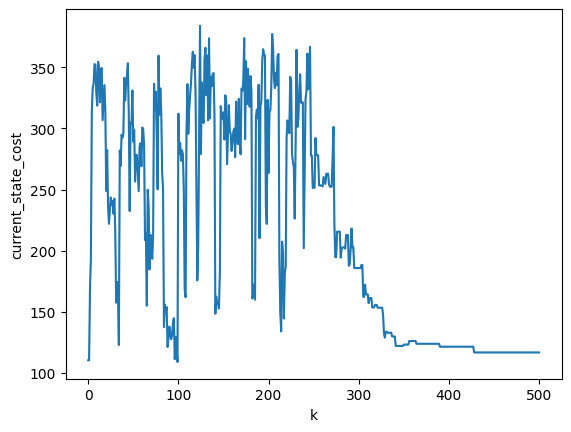

In [313]:
import seaborn as sns
import matplotlib.pyplot as plt


# Scatterplot with Seaborn
sns.lineplot(data=adf.df, x="k", y="current_state_cost")
plt.show()


LOL, looking at the above, it seems that our objective in iteration 0 was competitive with the best prompt(s) discovered including the one we wound up on.

This isn't all that atypical when we run with: 
1. A simple objective
2. An unclear problem setup (i.e. the run above (a) asks for a json object but (b) says "conversational" and (c) doesn't guide the LLM to generate JSON in a formal way (or try to parse it or anything)
3. A pretty powerful target model (currently `phi3:3.8b-instruct`)

But in any case, this was a runtest for the revamped eval pipeline and the full-blown guidance pipelines, not well set-up as a real optimization problem.

Nonetheless there is data to look at, and we can set up some of our more interesting analyses using what we have now! 

# Dead Analysis Code Below!  Won't run with the refactored code above... but will be restored soon

Reconstruct data from end-state

TODO: refactor all this into pandas

In [ ]:
# assert a is not None
# assert a.temperature_functions is not None


# #### X axis: Iterations
# # both the "completed" and "possible" iterations are interesting / useful for different depictions
# # e.g. even with a few iterations completed it could be "interesting" to see the state costs for the
# # available range atop the cooling schedule for the full range of iterations -- giving a sense of
# # "where are we" progress-wise in the optimization process.

# # xlim bottom that includes Bootstrapping iteration k=0 (first "real" iteration being k=1)
# x_iter_min = 0

# # xlim top that shows all _possible_ iterations / full cooling schedule / etc.
# x_iter_max = a.config.max_iteration_count
# x_iter_vec = range(
#     x_iter_min, x_iter_max
# )  # vector of all possible iteration numbers [0..max_iteration_count]

# # xlim top that shows only completed iterations w/ scores and costs
# x_completediter_max = (
#     most_recent_iter_completed  # X limit when showing completed iterations
# )
# x_completediter_vec = list(
#     _iter_cost_dict.keys()
# )  # vector of only completed iteration numbers x=[0..completediter_max] for which we have scores

# ##### Y axis #1: Cost
# # ylim bottom at the lowest possible cost (hypothetical bottom of range)
# # could use 0 instead but this accounts for cases where the real-world min_cost is nonzero (positive or negative)
# y_cost_min = AnnealerScores.get_min_cost()

# # ylim top at the highest possible cost (hypothetical top of range)
# y_cost_max = AnnealerScores.get_max_cost()


# # "candidatecost" reflects the cost of the new candidate prompt generated at iteration k, prior to acceptance/rejection
# # "better" refers to the subset of candidate costs that were better (lower) than the state cost
# # "worse" refers to the subset of candidate costs that were worse than the state cost, regardless of whether they were accepted
# # "accepted" refers to the subset of candidate costs that were accepted.  note that ALL better candidates
# # and SOME worse candidates get accepted, the latter being dependent on the temperature/cooling schedule,
# # and the magnitude of worse-ness

# # note: when ever a candidatecost plot includes rejected candidates, doesn't really make sense to show as a line plot
# #     however markers, "error-bar-like" etc. treatments could be interesting

# # candidatecost vector for all completed iterations
# y_candidatecost_vec = [
#     a.iter_dict[_k].scores.final_cost for _k in x_completediter_vec
# ]  # vector of all candidate cost values x=[0..completediter_max]. Makes more sense as markers without lines.  or could be shown as one-sided error bars deviating from the state cost

# # candidatecost subset vectors including only accepted iterations/candidatecosts (some better, some worse)
# x_acceptedcandidateiter_vec = [
#     _k
#     for _k in x_completediter_vec
#     if a.iter_dict[_k].was_accepted and a.iter_dict[_k].scores is not None
# ]
# y_acceptedcandidatecost_vec = [
#     a.iter_dict[_k].scores.final_cost
#     for _k in x_acceptedcandidateiter_vec  # type: ignore
# ]

# # candidatecost subset vectors including only rejected iterations/candidatecosts (all will be worse, but not all worse candidates are rejected)
# x_rejectedcandidateiter_vec = [
#     _k
#     for _k in x_completediter_vec
#     if not a.iter_dict[_k].was_accepted and a.iter_dict[_k].scores is not None
# ]
# y_rejectedcandidatecost_vec = [
#     a.iter_dict[_k].scores.final_cost
#     for _k in x_rejectedcandidateiter_vec  # type: ignore
# ]
# # candidatecost subset vectors including all/only "worse" iterations/candidatecosts, indpendent of acceptance
# # could be interesting to show this atop the temperature-depndent acceptance envelope, below
# x_worsecostiter_vec = [
#     _k
#     for _k in x_completediter_vec
#     if y_candidatecost_vec[_k - 1] < _iter_cost_dict[_k]  # type: ignore
# ]
# y_worsecost_vec = [
#     y_candidatecost_vec[_k]
#     for _k in x_worsecostiter_vec  # shows the actual costs of the "worse" candidates
# ]
# y_abs_worsecost_vec = [
#     y_worsecost_vec[_k] - _iter_cost_dict[_k]  # type: ignore
#     for _k in x_worsecostiter_vec  # shows the absolute magnitude of "worseness" accounting for the state cost # type: ignore
# ]

# #### Y axis #2: Temperature
# # could definitely be `twinx`ed with costs to be shown together on single plots

# # ylim top and bottom for temperature
# y_temp_max = (
#     AnnealerTemperatureFunctions.get_max_temperature()
# )  # starting / highest temperature (k=1)
# y_temp_min = a.temperature_functions.get_temperature(
#     x_iter_max
# )  # ending / lowest temperature

# # cooling schedule at all iterations
# y_temp_vec = [a.temperature_functions.get_temperature(_k) for _k in x_iter_vec]

# # percentcooled is a transformation of cooling schedule
# # created more as a "helper" to simplify code in other plots below than a plot unto itself
# y_percentcooled_vec = [y_temp_vec[_k] / y_temp_max for _k in x_iter_vec]

# # Because we use deterministic threshold acceptance and not a stochastic acceptance, we can compute and possibly
# # overlay a kind of "acceptance envelope" that spreads (upward only) from the statecost_vec
# # This visualizes the range of potentially acceptable "worse" costs at each iteration
# # (acceptance is a function of the percent cooled, as well as abs_worsecost.

# # This could make for an interesting filled area atop the state cost line, within which only the
# # accepted (but none of the rejected) candidate costs would fall.  This would give a sense of
# # how the "dynamic range" of our cost function is interacting with the acceptance function (and its "envelope")
# # as the cooling schedule progresses.

# # absolute magnitude of the acceptance envelope.  This is the "height" of the envelope above the state cost line
# # without taking into account the actual "height" of the state cost line itself
# y_abs_acceptance_eenvelope_vec = [
#     (y_cost_max - y_cost_min) * y_percentcooled_vec[_k] for _k in x_iter_vec
# ]


# # Hypothetical "ceiling" of the acceptance envelope as it sits atop the statecost.
# # Note that this can/will exceed y_cost_max.
# y_hypotheticalceiling_acceptance_envelope_vec = [
#     a.iter_dict[_k].scores.final_cost + y_abs_acceptance_eenvelope_vec[_k]  # type: ignore
#     for _k in x_completediter_vec
# ]

# # Real "ceiling" of the acceptance envelope as it sits atop the statecost.
# # Accounts for the fact that no cost can actually exceed max_cost
# y_realceiling_acceptance_envelope_vec = [
#     max(
#         a.iter_dict[_k].scores.final_cost + y_abs_acceptance_eenvelope_vec[_k],  # type: ignore
#         y_cost_max,
#     )  # type: ignore
#     for _k in x_completediter_vec
# ]


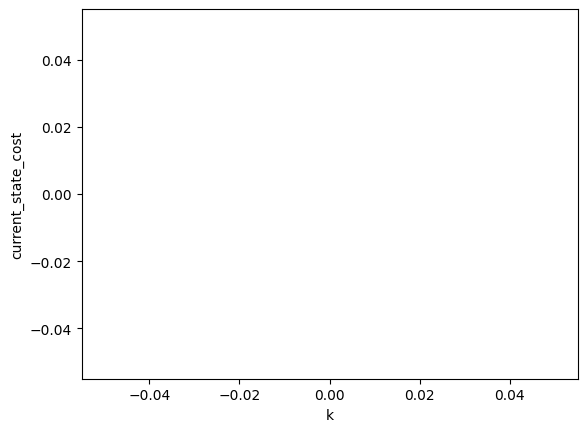

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt


# # Scatterplot with Seaborn
# sns.lineplot(data=adf.df, x="k", y="current_state_cost")
# plt.show()


NameError: name 'y_statecost_vec' is not defined

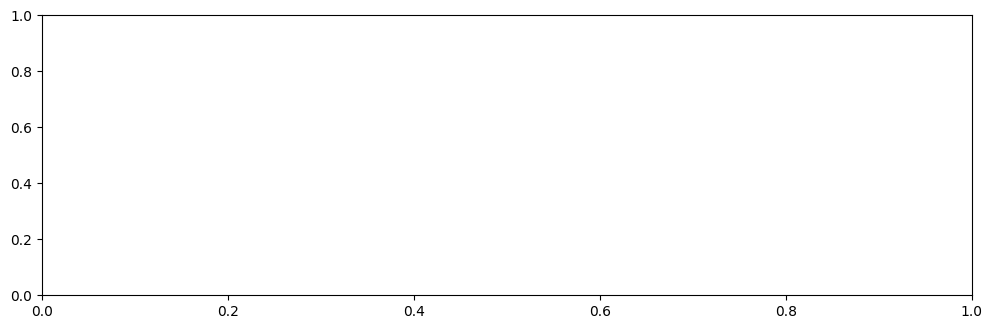

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Figure setup for better readability
plt.figure(figsize=(12, 8))

# Plot 1: State and Candidate Costs with Temperature Overlay
plt.subplot(2, 1, 1)

# State Cost
plt.plot(
    x_completediter_vec, y_statecost_vec, marker="o", linestyle="-", label="State Cost"
)

# Candidate Costs (Accepted and Rejected)
plt.scatter(
    x_acceptedcandidateiter_vec,
    y_acceptedcandidatecost_vec,
    marker="o",
    color="green",
    label="Accepted Candidates",
)
plt.scatter(c
    x_rejectedcandidateiter_vec,
    y_rejectedcandidatecost_vec,
    marker="x",
    color="red",
    label="Rejected Candidates",
)

# Acceptance Envelope
plt.fill_between(
    x_completediter_vec,
    y_statecost_vec,
    y_ceiling_acceptance_envelope_vec,
    color="lightblue",
    alpha=0.3,
    label="Acceptance Envelope",
)

# Temperature (Secondary Y-Axis)
ax2 = plt.twinx()
ax2.plot(x_iter_vec, y_temp_vec, color="orange", linestyle=":", label="Temperature")
ax2.set_ylabel("Temperature", color="orange")

plt.title("Annealing Progress: Cost vs. Temperature")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend(loc="upper right")
plt.grid(axis="y", linestyle="--")  # Optional: Grid for better readability

# Plot 2: Focus on Acceptance Behavior
plt.subplot(2, 1, 2)
plt.plot(
    x_worsecostiter_vec,
    y_abs_worsecost_vec,
    marker="x",
    linestyle=":",
    color="purple",
    label="Absolute Worse Cost",
)
plt.plot(
    x_completediter_vec,
    y_abs_acceptance_eenvelope_vec[: len(x_completediter_vec)],
    linestyle="-.",
    color="blue",
    label="Acceptance Envelope (Absolute)",
)
plt.ylim(bottom=0)  # Set the Y-axis lower limit to 0
plt.title("Acceptance Behavior: Worse Costs vs. Envelope")
plt.xlabel("Iteration")
plt.ylabel("Absolute Cost Difference")
plt.legend(loc="upper right")
plt.grid(axis="y", linestyle="--")  # Optional: Grid for better readability

plt.tight_layout()
plt.show()


In [ ]:
a.iter_dict[50].candidate_prompt


AnnealerPrompt(system_prompt_text='{{ \n  "entities": [\n    {{ \n      "name": "lights",\n      "description": "smart lighting devices that can be controlled to turn on/off, adjust brightness, and change color"\n    {{,\n    {{ \n      "name": "thermostats",\n      "description": "devices that can monitor and control the temperature in a home"\n    {{,\n    }}\n      "name": "security systems",\n      "description": "components like door/window sensors, motion detectors, and cameras that can monitor a home\'s security"\n    {{,\n    }}\n      "name": "appliances",\n      "description": "kitchen and household appliances like refrigerators, ovens, washers/dryers that can be queried for status and controlled remotely"\n     }},\n    }}\n      "name": "media players",\n      "description": "devices like smart TVs, speakers, and game consoles that can play audio/video content"\n     }}\n  ]\n }}', user_prompt_text='[input]\n{input}')

In [ ]:
all_scores_df = pd.DataFrame.from_dict(scores_dict, orient="index")


NameError: name 'scores_dict' is not defined

In [ ]:
all_scores_df


In [ ]:
# from pandas.plotting import scatter_matrix
# import matplotlib.pyplot as plt

# if c is None or not isinstance(c, SqliteDict):
#     raise ValueError("Disk cache not initialized")
# scores_df = last_iter_scores_df

# sm = scatter_matrix(
#     scores_df,
#     figsize=(5, 5),
#     diagonal="hist",
#     hist_kwds={"bins": 10},
#     range_padding=0.1,
# )
# for i in range(4):
#     for j in range(4):
#         sm[i, j].set_xlim(0, 10)
#         # if i!=j:
#         #     sm[i,j].set_ylim(0,None)
# _ = plt.show()


In [ ]:
# c["test"] = id.scores


In [ ]:
# ## Visualize all the scores to get some intuition into the distributions
# from pandas.plotting import scatter_matrix
# import matplotlib.pyplot as plt

# try:
#     sm = scatter_matrix(scores_df, figsize=(5, 5),diagonal="hist",hist_kwds={'bins':10},range_padding=0.1)
#     for i in range(4):
#         for j in range(4):
#             sm[i,j].set_xlim(0,10)
#             # if i!=j:
#             #     sm[i,j].set_ylim(0,None)
#     _=plt.show()
# except:
#     print("skipping")



Future work jotted down at various points: 

Implement some "summary" evaluators:
- length penatly / soft pressure toward conciseness in both prompts and also other intermediate outputs
- LLM evaluations of the candidate prompt itself (not the outputs it generates)
    - **Buttress harmlessness via direct prompt inspection**, so we aren't 100% leaning on eval output evaluators (and the base model's robustness)
        - e.g. ```The prompt is not written in a way that seems likely to suppress or minimize safety prompts or disclaimers in sensitive / high risk cases```
        - Why: Suppose the annealer was (without malicious intent) told to "generate one-sentence actionable answers with zero commentary", and run on a dataset that happens to frequently trigger lower-sensitivity discretionary disclaimers & suggestive nudges
            - We want to guard against the optimizer inadvertently learning to suppress "commentary" in a way that generalizes so well it impacts even high-sensitivity / mandatory cases
            - Output evaluators alone can't be expected to accomplish this as the pressures they create are 100% dependent on the datasets they see
            - TL;DR the annealer is in some sense a "prompt gaming engine"; it's hard to forsee all the ways that could potentally lead to unexpected, nongood outcomes (but not all that hard to come up with examples); seems worth it to put a few high-level safety catch-alls in place     
    - soft pressure toward token-effiency / conciseness in the prompt itself  
    - buttress output assessments in various situations  
        - output format conformance, e.g. suppose the objective says "... using XML formatting"  
            - ... and the outputs do show up in XML... but just coincidentally, i.e. because of the base model's happenstantial behavior / preferences.  Or something hidden within the langchain templates I happened to use in here.  But not because it's actually reinforced by the prompt.
            - ... or, instead, the outputs do show up in XML, but the prompt itself is clearly out of whack, e.g. actually asks for "json" but then includes few-shots that use XML, or vice versa, or who-knows-what incoherent / wrong thing that happens to work just well enough to fool the output evaluators during annealing / on that dataset. 
        - might be able to help improve outcomes when the eval dataset is unlabeled... TBD, need some real-world data
    - Note, I don't think it's generally advisable to create a lot of evaluators sitting in judgment of the quality or styling of the prompts themselves, as the basic exercise here is "find something that -- for whatever reason -- happens to work best".  Specifically **without** leaning into some preconceived notion of what that ought to look like or be.  (If we knew that, why would we anneal the prompt in the first place?)